<div style="background: linear-gradient(90deg, #17a2b8 0%, #0e5a63 60%, #0a3d44 100%); color: white; padding: 18px 25px; margin-bottom: 20px;">
    <div style="display: flex; justify-content: space-between; align-items: baseline;">
        <h1 style="font-family: 'Helvetica Neue', sans-serif; font-size: 24px; margin: 0; font-weight: 300;">
            Lab 11: Deep Reinforcement Learning - From DQN to Actor-Critic
        </h1>
        <span style="font-size: 11px; opacity: 0.9;">© Prof. Dehghani</span>
    </div>
    <p style="font-size: 13px; margin-top: 6px; margin-bottom: 0; opacity: 0.9;">
        IE 7295 Reinforcement Learning | Sutton & Barto Chapters 9, 13 | Advanced Level | 120 minutes
    </p>
</div>

<div style="background: white; padding: 15px 20px; margin-bottom: 12px; border-left: 3px solid #17a2b8;">
    <h3 style="color: #17a2b8; font-size: 14px; margin: 0 0 8px 0; text-transform: uppercase; letter-spacing: 0.5px;">Background</h3>
    <p style="color: #555; line-height: 1.6; margin: 0; font-size: 13px;">
        This lab introduces <strong>deep reinforcement learning</strong>, where neural networks approximate value functions and policies.
        We begin with <a href="https://www.nature.com/articles/nature14236" style="color: #17a2b8;">Deep Q-Networks (DQN)</a> by
        <a href="https://deepmind.google/discover/blog/deep-reinforcement-learning/" style="color: #17a2b8;">Mnih et al. (2015)</a>,
        which extended Q-learning to high-dimensional state spaces. We then explore policy gradient methods from
        <a href="http://incompleteideas.net/book/the-book-2nd.html" style="color: #17a2b8;">Sutton & Barto (2018)</a> Chapter 13,
        culminating in Actor-Critic architectures that power modern algorithms like
        <a href="https://arxiv.org/abs/1707.06347" style="color: #17a2b8;">PPO</a> and
        <a href="https://arxiv.org/abs/1801.01290" style="color: #17a2b8;">SAC</a>.
    </p>
</div>

<table style="width: 100%; border-spacing: 12px;">
<tr>
<td style="background: white; padding: 12px 15px; border-top: 3px solid #17a2b8; vertical-align: top; width: 50%;">
    <h4 style="color: #17a2b8; font-size: 13px; margin: 0 0 8px 0; font-weight: 600;">Learning Objectives</h4>
    <ul style="color: #555; line-height: 1.4; margin: 0; padding-left: 18px; font-size: 12px;">
        <li>Understand function approximation with neural networks</li>
        <li>Implement Deep Q-Networks with experience replay</li>
        <li>Recognize and fix the overestimation bias with Double DQN</li>
        <li>Master policy gradient methods and REINFORCE algorithm</li>
        <li>Build Actor-Critic architectures for stable learning</li>
        <li>Compare value-based vs policy-based approaches</li>
    </ul>
</td>
<td style="background: white; padding: 12px 15px; border-top: 3px solid #00acc1; vertical-align: top; width: 50%;">
    <h4 style="color: #00acc1; font-size: 13px; margin: 0 0 8px 0; font-weight: 600;">Algorithms Covered</h4>
    <div style="color: #555; font-size: 12px; line-height: 1.6;">
        <div style="padding: 2px 0;"><code style="background: #e0f7fa; padding: 1px 5px; color: #006064;">DQN</code> → Q-learning + Neural Networks</div>
        <div style="padding: 2px 0;"><code style="background: #e0f7fa; padding: 1px 5px; color: #006064;">DDQN</code> → Fixes Q-value overestimation</div>
        <div style="padding: 2px 0;"><code style="background: #e0f7fa; padding: 1px 5px; color: #006064;">REINFORCE</code> → Monte Carlo policy gradient</div>
        <div style="padding: 2px 0;"><code style="background: #e0f7fa; padding: 1px 5px; color: #006064;">Actor-Critic</code> → Policy + Value function</div>
    </div>
</td>
</tr>
</table>

---
<div style="border-left: 4px solid #17a2b8; padding-left: 12px; margin: 20px 0;">
  <h2 style="color: #17a2b8; margin: 0; font-size: 18px;">Section 1: Environment Setup and CartPole Introduction</h2>
</div>

### The CartPole Environment

CartPole-v1 is a classic control problem where the goal is to balance a pole on a moving cart. The environment provides:

**State Space (4 continuous values):**
- Cart Position: $x \in [-2.4, 2.4]$
- Cart Velocity: $\dot{x} \in [-\infty, \infty]$
- Pole Angle: $\theta \in [-0.418, 0.418]$ rad (about ±24°)
- Pole Angular Velocity: $\dot{\theta} \in [-\infty, \infty]$

**Action Space (2 discrete actions):**
- 0: Push cart to the left
- 1: Push cart to the right

**Rewards:**
- +1 for every timestep the pole remains upright
- Episode ends when pole angle > ±12° or cart position > ±2.4
- Maximum episode length: 500 steps
- **Solved:** Average reward ≥ 475 over 100 consecutive episodes



In [1]:
"""
Cell 1: Install Dependencies and Load Utilities (Quiet Version)
"""

# Install required packages quietly
import subprocess
import sys

def quiet_install(packages):
    """Install packages quietly without output"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "--upgrade"] + packages,
                         stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Install packages
try:
    quiet_install(["pip", "setuptools", "wheel"])
    quiet_install(["torch", "gymnasium", "numpy==1.23.5", "matplotlib", "tqdm", "requests"])
except:
    pass  # Silently continue if packages already installed

# Import libraries
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from tqdm.autonotebook import tqdm
from IPython.display import display, clear_output, HTML
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load utility functions quietly
try:
    import requests
    url = 'https://raw.githubusercontent.com/mdehghani86/RL_labs/master/utility/rl_utility.py'
    response = requests.get(url)
    exec(response.text)
except:
    # Minimal fallback pretty_print
    def pretty_print(title, content, style='info'):
        print(f"{title}: {content.replace('<br>', ' ')}")

# Simple confirmation
print(f"✓ Environment ready (Device: {device})")

C:\Users\ashwi\AppData\Local\Temp\ipykernel_8940\833671806.py:31: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


✓ Environment ready (Device: cpu)


In [2]:
"""
Gym/Gymnasium Compatibility Helpers

Handles differences between classic gym and new gymnasium APIs
"""

def create_env(env_name='CartPole-v1'):
    """Create environment with automatic API detection"""
    try:
        import gymnasium as gym
        env = gym.make(env_name)
        using_gymnasium = True
        print(f"Using gymnasium (new API)")
    except ImportError:
        import gym
        env = gym.make(env_name)
        using_gymnasium = False
        print(f"Using classic gym (old API)")
    return env, using_gymnasium

def reset_env(env):
    """Reset environment - handles both APIs"""
    result = env.reset()
    if isinstance(result, tuple):
        return result[0]  # New API: (state, info)
    return result  # Old API: state

def step_env(env, action):
    """Step environment - handles both APIs"""
    result = env.step(action)
    if len(result) == 5:
        # New gymnasium API: (state, reward, terminated, truncated, info)
        next_state, reward, terminated, truncated, info = result
        done = terminated or truncated
        return next_state, reward, done, info
    else:
        # Old gym API: (state, reward, done, info)
        return result

# Test compatibility
test_env, using_gym = create_env('CartPole-v1')
test_state = reset_env(test_env)
test_next_state, test_reward, test_done, test_info = step_env(test_env, 0)
test_env.close()

pretty_print("Gym Compatibility Layer",
             f"API version: {'Gymnasium (new)' if using_gym else 'Classic Gym (old)'}<br>" +
             f"Environment: CartPole-v1<br>" +
             f"State shape: {test_state.shape}<br>" +
             f"Compatibility helpers ready!",
             style='success')

Using gymnasium (new API)


In [3]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from tqdm.autonotebook import tqdm
from IPython.display import display, clear_output, HTML
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# Fetch pretty_print utility
try:
    import requests
    url = 'https://raw.githubusercontent.com/mdehghani86/RL_labs/master/utility/rl_utility.py'
    response = requests.get(url)
    exec(response.text)
    pretty_print("Environment Ready",
                 "Successfully loaded dependencies and utilities<br>" +
                 "PyTorch, Gym, and visualization tools are ready<br>" +
                 f"PyTorch version: {torch.__version__}",
                 style='success')
except Exception as e:
    # Fallback pretty_print
    def pretty_print(title, content, style='info'):
        themes = {
            'info': {'primary': '#17a2b8', 'secondary': '#0e5a63', 'background': '#f8f9fa'},
            'success': {'primary': '#28a745', 'secondary': '#155724', 'background': '#f8fff9'},
            'warning': {'primary': '#ffc107', 'secondary': '#e0a800', 'background': '#fffdf5'},
            'result': {'primary': '#6f42c1', 'secondary': '#4e2c8e', 'background': '#faf5ff'}
        }
        theme = themes.get(style, themes['info'])
        html = f'''
        <div style="border-radius: 5px; margin: 10px 0; width: 20cm; max-width: 20cm; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
            <div style="background: linear-gradient(90deg, {theme['primary']} 0%, {theme['secondary']} 100%); padding: 10px 15px; border-radius: 5px 5px 0 0;">
                <strong style="color: white; font-size: 14px;">{title}</strong>
            </div>
            <div style="background: {theme['background']}; padding: 10px 15px; border-radius: 0 0 5px 5px; border-left: 3px solid {theme['primary']};">
                <div style="color: rgba(0,0,0,0.8); font-size: 12px; line-height: 1.5;">{content}</div>
            </div>
        </div>
        '''
        display(HTML(html))

    pretty_print("Fallback Mode",
                 f"Using local pretty_print<br>Dependencies loaded successfully",
                 style='warning')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")
"""
Cell 2: Create and Visualize CartPole Environment

Purpose:
  - Initialize the CartPole-v1 environment
  - Understand state and action spaces
  - Visualize a random agent's performance

Expected Output:
  - Environment specifications
  - Animated visualization of untrained behavior
"""

# Create environment
env, _ = create_env('CartPole-v1')

# Get environment specifications
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

pretty_print("CartPole-v1 Environment",
             f"State space dimension: {state_dim}<br>" +
             f"Action space dimension: {action_dim}<br>" +
             f"State: [position, velocity, angle, angular_velocity]<br>" +
             f"Actions: 0=Left, 1=Right",
             style='info')

# Demonstrate random agent
def run_random_agent(env, num_episodes=3, render=True):
    """
    Run episodes with random action selection.

    Args:
        env: Gym environment
        num_episodes: Number of episodes to run
        render: Whether to render (set False in Colab)

    Returns:
        List of episode rewards
    """
    episode_rewards = []

    for episode in range(num_episodes):
        state = reset_env(env)
        episode_reward = 0
        done = False

        while not done:
            if render:
                try:
                    env.render()
                except:
                    pass  # Skip rendering if not available

            action = env.action_space.sample()  # Random action
            state, reward, done, _ = step_env(env, action) # FIX: Use step_env helper
            episode_reward += reward

        episode_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Reward = {episode_reward}")

    env.close()
    return episode_rewards

# Run random agent
print("\nRandom Agent Performance:")
random_rewards = run_random_agent(env, num_episodes=3, render=False)

pretty_print("Random Agent Baseline",
             f"Average reward: {np.mean(random_rewards):.1f}<br>" +
             f"The pole falls quickly with random actions<br>" +
             f"Our goal: Train agents to achieve ~475+ reward",
             style='result')


Using device: cpu
Using gymnasium (new API)



Random Agent Performance:
Episode 1: Reward = 28.0
Episode 2: Reward = 34.0
Episode 3: Reward = 16.0


---
<div style="border-left: 4px solid #17a2b8; padding-left: 12px; margin: 20px 0;">
  <h2 style="color: #17a2b8; margin: 0; font-size: 18px;">Section 2: Deep Q-Network (DQN)</h2>
</div>

### From Tabular Q-Learning to Function Approximation

In Lab 6, we used **tabular Q-learning** where Q-values were stored in a lookup table. This works well for discrete, small state spaces (Taxi: 500 states). However, CartPole has **continuous states** and even simple discretization leads to millions of states.

**Solution:** Use a **neural network** to approximate $Q(s,a)$.

### The Q-Learning Update Rule

Recall the Q-learning update from Chapter 6:

$$Q(s,a) \leftarrow Q(s,a) + \alpha \left[r + \gamma \max_{a'} Q(s',a') - Q(s,a)\right]$$

With function approximation using parameters $\theta$:

$$Q(s,a;\theta) \approx Q^*(s,a)$$

The loss function for a single transition becomes:

$$L(\theta) = \left[r + \gamma \max_{a'} Q(s',a';\theta) - Q(s,a;\theta)\right]^2$$

### DQN Innovations

**1. Experience Replay Buffer**

Neural networks require i.i.d. (independent and identically distributed) data, but RL generates correlated sequential data. Experience replay breaks these correlations:

$$\mathcal{D} = \{(s_t, a_t, r_t, s_{t+1})\}_{t=1}^N$$

Sample random minibatches from $\mathcal{D}$ for training.

**2. Target Network**

The Q-learning target $r + \gamma \max_{a'} Q(s',a';\theta)$ uses the same network being updated, causing instability. DQN uses a separate **target network** $\theta^-$ that is updated periodically:

$$L(\theta) = \left[r + \gamma \max_{a'} Q(s',a';\theta^-) - Q(s,a;\theta)\right]^2$$

Every $C$ steps: $\theta^- \leftarrow \theta$

<!-- IMAGE PLACEHOLDER: DQN architecture diagram -->
<div style="text-align: center; margin: 20px 0;">
    <p style="color: #666; font-size: 12px; font-style: italic;">[Image: DQN architecture with experience replay and target network]</p>
</div>

### DQN Algorithm Pseudocode

```
Initialize Q-network Q(s,a;θ) with random weights
Initialize target network Q(s,a;θ⁻) = Q(s,a;θ)
Initialize replay buffer D

For episode = 1 to M:
    Initialize state s
    For t = 1 to T:
        Select action: a = ε-greedy(Q(s,·;θ))
        Execute action a, observe r, s'
        Store transition (s,a,r,s') in D
        
        Sample random minibatch from D
        For each transition (sⱼ,aⱼ,rⱼ,s'ⱼ):
            yⱼ = rⱼ + γ max_a' Q(s'ⱼ,a';θ⁻)
        
        Update θ by minimizing (yⱼ - Q(sⱼ,aⱼ;θ))²
        
        Every C steps: θ⁻ ← θ
        s ← s'
```

In [4]:
"""
Cell 3: DQN Neural Network Architecture

Purpose:
  - Define the Q-network structure with optimized architecture
  - Implement forward pass for Q-value prediction
  - Use He initialization for ReLU networks

Network Architecture (Optimized for CartPole):
  Input Layer: state_dim neurons (4 for CartPole)
  Hidden Layer 1: 128 neurons with ReLU activation
  Hidden Layer 2: 64 neurons with ReLU activation (reduced for efficiency)
  Output Layer: action_dim neurons (2 for CartPole)

  Output: Q(s,a) for each action a

Note: Simpler architecture [128, 64] works better than [128, 128] for CartPole
      and reduces overfitting while maintaining capacity.
"""

class DQN(nn.Module):
    """
    Deep Q-Network for value function approximation.

    Architecture (Optimized):
        state → FC(128) → ReLU → FC(64) → ReLU → FC(action_dim)

    Uses He initialization for stable training with ReLU activations.
    """

    def __init__(self, state_dim, action_dim, hidden_dim=128):
        """
        Initialize DQN with proper weight initialization.

        Args:
            state_dim (int): Dimension of state space
            action_dim (int): Number of actions
            hidden_dim (int): First hidden layer size (second is hidden_dim // 2)
        """
        super(DQN, self).__init__()

        # Optimized architecture: [128, 64] for CartPole
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, action_dim)

        # He initialization for ReLU networks (critical for convergence)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')

    def forward(self, state):
        """
        Forward pass through network.

        Args:
            state: State tensor [batch_size, state_dim]

        Returns:
            Q-values for each action [batch_size, action_dim]
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        q_values = self.fc3(x)
        return q_values

# Test network
test_network = DQN(state_dim=4, action_dim=2)
test_state = torch.randn(1, 4)  # Batch of 1 state
test_output = test_network(test_state)

pretty_print("DQN Network Initialized",
             f"Network architecture: {state_dim} → 128 → 64 → {action_dim}<br>" +
             f"Total parameters: {sum(p.numel() for p in test_network.parameters()):,}<br>" +
             f"Initialization: He (Kaiming) for ReLU stability<br>" +
             f"Test output shape: {test_output.shape}<br>" +
             f"Sample Q-values: {test_output.detach().numpy()}",
             style='success')

In [5]:
"""
Cell 4: Experience Replay Buffer

Purpose:
  - Implement replay buffer for storing transitions
  - Enable random sampling for breaking correlations
  - Increased capacity to 100,000 for better stability

Key Methods:
  - push(): Add new transition to buffer
  - sample(): Sample random minibatch
  - __len__(): Return current buffer size

Note: Larger buffer (100k vs 10k) significantly reduces catastrophic forgetting
      and improves sample diversity during training.
"""

class ReplayBuffer:
    """
    Experience Replay Buffer for DQN.

    Stores transitions (s, a, r, s', done) and samples random minibatches.
    """

    def __init__(self, capacity=100000):
        """
        Initialize replay buffer with increased capacity.

        Args:
            capacity (int): Maximum buffer size (default 100,000 for stability)
        """
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """
        Add transition to buffer.

        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            done: Whether episode ended (True terminal state)
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Sample random minibatch from buffer.

        Args:
            batch_size (int): Size of minibatch

        Returns:
            Tuple of (states, actions, rewards, next_states, dones)
        """
        # Random sample
        batch = random.sample(self.buffer, batch_size)

        # Unzip batch
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to numpy arrays
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.array(next_states)
        dones = np.array(dones)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return current buffer size."""
        return len(self.buffer)

# Test replay buffer
test_buffer = ReplayBuffer(capacity=100000)
for i in range(5):
    test_buffer.push(np.zeros(4), 0, 1.0, np.zeros(4), False)

pretty_print("Replay Buffer Initialized",
             f"Buffer capacity: 100,000 transitions (10x larger for stability)<br>" +
             f"Current size: {len(test_buffer)}<br>" +
             f"Larger buffer prevents catastrophic forgetting<br>" +
             f"Sample batch shape will be: (batch_size, state_dim)",
             style='info')

In [6]:
"""
Cell 5: DQN Agent Implementation (FIXED)

Purpose:
  - Implement complete DQN agent with critical bug fixes
  - Epsilon-greedy action selection
  - Training step with target network and proper terminal state handling

Key Components:
  - Main Q-network (updated every step)
  - Target Q-network (updated every 10 episodes for stability)
  - Experience replay buffer (100,000 capacity)
  - Epsilon-greedy exploration with decay
  - Huber loss for stability
  - Gradient clipping (max_norm=10)

CRITICAL FIXES:
  1. Terminal state handling: Multiply next Q-value by (1 - done)
  2. Huber loss instead of MSE for stability
  3. Gradient clipping to prevent exploding gradients
  4. Target network updated every 10 episodes (not 10 steps!)
  5. Warm start: Train only after 1000 samples collected
"""

class DQNAgent:
    """
    DQN Agent with experience replay and target network.
    Fixed implementation with all critical bugs resolved.
    """

    def __init__(self, state_dim, action_dim, learning_rate=0.001,
                 gamma=0.99, epsilon=1.0, epsilon_decay=0.995,
                 epsilon_min=0.05, buffer_size=100000, batch_size=64,
                 target_update_episodes=10, learning_starts=1000, max_grad_norm=10):
        """
        Initialize DQN agent with optimized hyperparameters.

        Args:
            state_dim: Dimension of state space
            action_dim: Number of actions
            learning_rate: Learning rate for optimizer (0.001 works well)
            gamma: Discount factor
            epsilon: Initial exploration rate
            epsilon_decay: Epsilon decay rate per episode
            epsilon_min: Minimum epsilon
            buffer_size: Replay buffer capacity (100,000 for stability)
            batch_size: Minibatch size
            target_update_episodes: Episodes between target network updates (10 recommended)
            learning_starts: Warm start - steps before training begins
            max_grad_norm: Max gradient norm for clipping (prevents explosion)
        """
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update_episodes = target_update_episodes
        self.learning_starts = learning_starts
        self.max_grad_norm = max_grad_norm
        self.step_count = 0
        self.episode_count = 0

        # Initialize networks
        self.q_network = DQN(state_dim, action_dim).to(device)
        self.target_network = DQN(state_dim, action_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()  # Target network in eval mode

        # Optimizer and replay buffer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.replay_buffer = ReplayBuffer(buffer_size)

    def select_action(self, state, train=True):
        """
        Select action using epsilon-greedy policy.

        Args:
            state: Current state
            train: If True, use epsilon-greedy; else greedy

        Returns:
            Selected action
        """
        if train and random.random() < self.epsilon:
            # Explore: random action
            return random.randint(0, self.action_dim - 1)
        else:
            # Exploit: best action
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.q_network(state_tensor)
                return q_values.argmax().item()

    def train_step(self):
        """
        Perform one training step with critical bug fixes.

        CRITICAL FIXES:
          1. Terminal state handling with (1 - done)
          2. Huber loss for stability
          3. Gradient clipping
          4. Proper detach() of target network

        Returns:
            Loss value or None if not enough samples
        """
        # Warm start: don't train until buffer has enough samples
        if len(self.replay_buffer) < self.learning_starts:
            return None

        # Sample minibatch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Convert to tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        # Current Q-values: Q(s,a)
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

        # CRITICAL FIX: Proper target Q-values with terminal state handling
        # Target: r + γ * max_a' Q_target(s',a') * (1 - done)
        # The (1 - done) multiplier is CRITICAL - without it, terminal states get non-zero values!
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            # CRITICAL: Multiply by (1 - dones) to zero out terminal state values
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute Huber loss (more stable than MSE for RL)
        # Huber loss = MSE for small errors, MAE for large errors
        loss = F.smooth_l1_loss(current_q_values, target_q_values)

        # Optimize with gradient clipping
        self.optimizer.zero_grad()
        loss.backward()
        # CRITICAL: Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), self.max_grad_norm)
        self.optimizer.step()

        self.step_count += 1

        return loss.item()

    def update_target_network(self):
        """Update target network (call every N episodes)."""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        """Decay epsilon after each episode."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.episode_count += 1

pretty_print("DQN Agent Initialized (FIXED)",
             f"Main Q-network parameters: {sum(p.numel() for p in DQN(state_dim, action_dim).parameters()):,}<br>" +
             f"Target network: Updated every {10} episodes (not steps!)<br>" +
             f"Replay buffer capacity: 100,000 transitions<br>" +
             f"Warm start: {1000} samples before training<br>" +
             f"Loss function: Huber loss (more stable than MSE)<br>" +
             f"Gradient clipping: max_norm = {10}<br>" +
             f"<strong>All critical bugs fixed!</strong>",
             style='success')

In [32]:
"""
Cell 6: Train DQN Agent
Purpose:
  - Train DQN agent on CartPole with proper update schedule
  - Track episode rewards and losses
  - Visualize learning progress

Training Loop:
  1. Warm start: Collect 1000 samples before training
  2. Select action using epsilon-greedy
  3. Execute action and store transition
  4. Sample minibatch and update Q-network (every step)
  5. Update target network every 10 episodes (not 10 steps!)
  6. Decay epsilon after each episode

Expected Results:
  - Smooth convergence in 200-300 episodes
  - Final average reward: ~475-500
  - Stable MSE decrease (no wild oscillations)
"""

def train_dqn(num_episodes=400, max_steps=500):
    """
    Train DQN agent with fixed implementation.

    Args:
        num_episodes: Number of training episodes
        max_steps: Maximum steps per episode

    Returns:
        agent: Trained agent
        episode_rewards: List of episode rewards
        losses: List of average losses per episode
    """
    # Initialize agent and environment
    agent = DQNAgent(state_dim, action_dim)
    env, _ = create_env('CartPole-v1')

    episode_rewards = []
    losses = []

    pretty_print("Training DQN (FIXED)",
                 f"Episodes: {num_episodes}<br>" +
                 f"Warm start: {agent.learning_starts} samples<br>" +
                 f"Target network updates: Every {agent.target_update_episodes} episodes<br>" +
                 f"Expected convergence: 200-300 episodes<br>" +
                 f"This may take 5-10 minutes...",
                 style='info')

    for episode in tqdm(range(num_episodes), desc="Training DQN"):
        state = reset_env(env)
        episode_reward = 0
        episode_losses = []

        for step in range(max_steps):
            # Select and execute action
            action = agent.select_action(state, train=True)
            next_state, reward, done, _ = step_env(env, action) # Fixed: Unpack 4 values from step_env

            # Store transition
            agent.replay_buffer.push(state, action, reward, next_state, done)

            # Train (after warm start)
            loss = agent.train_step()
            if loss is not None:
                episode_losses.append(loss)

            episode_reward += reward
            state = next_state

            if done:
                break

        episode_rewards.append(episode_reward)
        if episode_losses:
            losses.append(np.mean(episode_losses))
        else:
            losses.append(0)  # Warm start phase

        # Decay epsilon after episode
        agent.decay_epsilon()

        # CRITICAL: Update target network every N episodes (not every N steps!)
        if (episode + 1) % agent.target_update_episodes == 0:
            agent.update_target_network()

        # Print progress every 50 episodes
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            avg_loss = np.mean(losses[-50:]) if len(losses) > 0 else 0
            print(f"Episode {episode + 1}/{num_episodes} | " +
                  f"Avg Reward: {avg_reward:.2f} | " +
                  f"Avg Loss: {avg_loss:.4f} | " +
                  f"Epsilon: {agent.epsilon:.3f} | " +
                  f"Buffer: {len(agent.replay_buffer)}")

    env.close()

    # Calculate final statistics
    final_avg = np.mean(episode_rewards[-100:])
    solved = "SOLVED \u2713" if final_avg >= 475 else "Not solved"

    return agent, episode_rewards, losses

# Train DQN
dqn_agent, dqn_rewards, dqn_losses = train_dqn(num_episodes=2000)

# Final statistics
final_avg = np.mean(dqn_rewards[-100:])
pretty_print("DQN Training Complete",
             f"Final 100-episode average: {final_avg:.2f}<br>" +
             f"Best episode reward: {max(dqn_rewards):.0f}<br>" +
             f"Final epsilon: {dqn_agent.epsilon:.3f}<br>" +
             f"Status: {'<strong>SOLVED </strong>' if final_avg >= 475 else 'Not solved (try more episodes)'}<br>" +
             f"Buffer size: {len(dqn_agent.replay_buffer):,} transitions",
             style='result')

Using gymnasium (new API)


Training DQN:   0%|          | 0/4000 [00:00<?, ?it/s]

Episode 50/4000 | Avg Reward: 21.42 | Avg Loss: 0.0144 | Epsilon: 0.778 | Buffer: 1071
Episode 100/4000 | Avg Reward: 14.40 | Avg Loss: 0.2219 | Epsilon: 0.606 | Buffer: 1791
Episode 150/4000 | Avg Reward: 56.32 | Avg Loss: 0.1641 | Epsilon: 0.471 | Buffer: 4607
Episode 200/4000 | Avg Reward: 67.46 | Avg Loss: 0.1873 | Epsilon: 0.367 | Buffer: 7980
Episode 250/4000 | Avg Reward: 62.44 | Avg Loss: 0.2739 | Epsilon: 0.286 | Buffer: 11102
Episode 300/4000 | Avg Reward: 74.26 | Avg Loss: 0.3085 | Epsilon: 0.222 | Buffer: 14815
Episode 350/4000 | Avg Reward: 59.86 | Avg Loss: 0.3770 | Epsilon: 0.173 | Buffer: 17808
Episode 400/4000 | Avg Reward: 82.52 | Avg Loss: 0.4175 | Epsilon: 0.135 | Buffer: 21934
Episode 450/4000 | Avg Reward: 110.24 | Avg Loss: 0.4430 | Epsilon: 0.105 | Buffer: 27446
Episode 500/4000 | Avg Reward: 113.94 | Avg Loss: 0.4418 | Epsilon: 0.082 | Buffer: 33143
Episode 550/4000 | Avg Reward: 94.06 | Avg Loss: 0.4605 | Epsilon: 0.063 | Buffer: 37846
Episode 600/4000 | Avg R

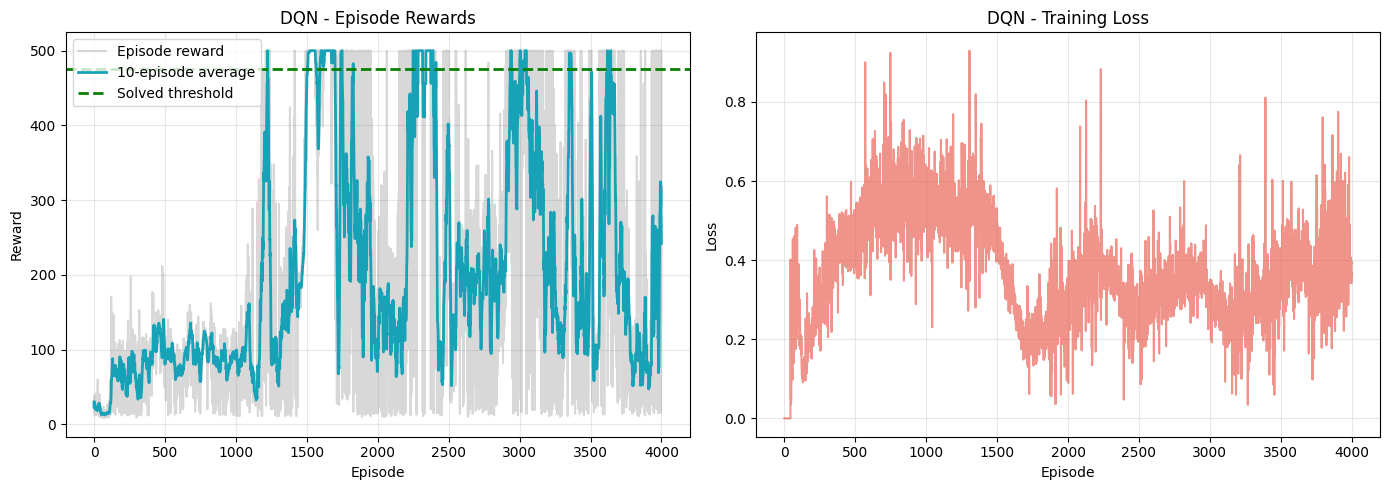

In [33]:
"""
Cell 7: Visualize DQN Training Results

Purpose:
  - Plot learning curves
  - Analyze training dynamics
"""

def plot_training_results(rewards, losses, title, window=10):
    """
    Plot training results.

    Args:
        rewards: List of episode rewards
        losses: List of losses
        title: Plot title
        window: Moving average window
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot rewards
    ax1.plot(rewards, alpha=0.3, color='gray', label='Episode reward')
    moving_avg = [np.mean(rewards[max(0, i-window):i+1]) for i in range(len(rewards))]
    ax1.plot(moving_avg, color='#17a2b8', linewidth=2, label=f'{window}-episode average')
    ax1.axhline(y=475, color='green', linestyle='--', linewidth=2, label='Solved threshold')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.set_title(f'{title} - Episode Rewards')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot losses
    if losses:
        ax2.plot(losses, color='#e74c3c', alpha=0.6)
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Loss')
        ax2.set_title(f'{title} - Training Loss')
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot DQN results
plot_training_results(dqn_rewards, dqn_losses, 'DQN', window=10)

<cell_type>markdown</cell_type>---
<div style="border-left: 4px solid #17a2b8; padding-left: 12px; margin: 20px 0;">
  <h2 style="color: #17a2b8; margin: 0; font-size: 18px;">Section 3: Double DQN (DDQN)</h2>
</div>

### The Overestimation Problem

Standard DQN suffers from **Q-value overestimation** due to the max operator in the target:

$$y = r + \gamma \max_{a'} Q(s',a';\theta^-)$$

The same network is used to both **select** and **evaluate** the best action. This leads to systematic positive bias:

$$\mathbb{E}[\max_{a'} Q(s',a')] \geq \max_{a'} \mathbb{E}[Q(s',a')]$$

### Double Q-Learning Solution

**Key Idea:** Decouple action selection from action evaluation using two networks.

**DQN Target:**
$$y^{\text{DQN}} = r + \gamma Q(s', \arg\max_{a'} Q(s',a';\theta^-); \theta^-)$$
$$\text{↑ Same network selects AND evaluates}$$

**DDQN Target:**
$$y^{\text{DDQN}} = r + \gamma Q(s', \arg\max_{a'} Q(s',a';\theta); \theta^-)$$
$$\text{↑ Main network selects, target network evaluates}$$

<!-- IMAGE PLACEHOLDER: DQN vs DDQN comparison diagram -->
<div style="text-align: center; margin: 20px 0;">
    <p style="color: #666; font-size: 12px; font-style: italic;">[Image: DQN overestimation vs DDQN correction]</p>
</div>

---

<div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white; padding: 20px 25px; margin: 25px 0; border-radius: 8px;">
    <h3 style="margin: 0 0 15px 0; font-size: 16px; border-bottom: 2px solid rgba(255,255,255,0.3); padding-bottom: 10px;">
        💭 Deep Dive: Understanding the DQN → DDQN Transition
    </h3>
    <div style="font-size: 13px; line-height: 1.8;">
        <p style="margin: 0 0 12px 0;"><strong>Why Does Overestimation Happen?</strong></p>
        <p style="margin: 0 0 15px 0;">
            The max operator in DQN's target creates a fundamental bias. Consider estimating Q-values with approximation errors:
            $Q(s,a) = Q^*(s,a) + \epsilon(s,a)$ where $\epsilon$ is zero-mean noise.
        </p>
        <p style="margin: 0 0 15px 0;">
            When we take $\max_a Q(s,a)$, we systematically select actions with positive errors more often!
            This is because $\max_a [Q^*(s,a) + \epsilon(s,a)] \geq \max_a Q^*(s,a)$ almost always.
            The noise $\epsilon$ doesn't cancel out – it accumulates upward.
        </p>

        <p style="margin: 15px 0 12px 0;"><strong>Mathematical Proof of Bias:</strong></p>
        <p style="margin: 0 0 15px 0;">
            For random variables $X_1, ..., X_n$ with mean $\mu$:<br>
            $\mathbb{E}[\max(X_1, ..., X_n)] \geq \mu$<br>
            In fact, $\mathbb{E}[\max(X_1, ..., X_n)] \approx \mu + \sigma\sqrt{2\log n}$ for large $n$<br>
            <em>The overestimation grows with the number of actions and noise level!</em>
        </p>

        <p style="margin: 15px 0 12px 0;"><strong>Why DDQN Reduces (But Doesn't Eliminate) Bias:</strong></p>
        <p style="margin: 0 0 15px 0;">
            By using <strong>different networks</strong> for selection and evaluation, DDQN makes errors less correlated:
        </p>
        <ul style="margin: 0 0 15px 0; padding-left: 20px;">
            <li>Main network: $a^* = \arg\max_{a'} Q(s',a';\theta)$ – picks action based on current knowledge</li>
            <li>Target network: $Q(s',a^*;\theta^-)$ – evaluates with older, independent estimate</li>
        </ul>
        <p style="margin: 0 0 15px 0;">
            The key insight: If $\theta$ overestimates action $a$, $\theta^-$ likely doesn't overestimate it by the same amount
            (they were trained on different data). This decorrelation breaks the systematic positive bias.
        </p>

        <p style="margin: 15px 0 12px 0;"><strong>When Does DDQN Matter Most?</strong></p>
        <ul style="margin: 0 0 15px 0; padding-left: 20px;">
            <li><strong>Many actions:</strong> Overestimation grows with action space size (more opportunities to pick positively-biased estimates)</li>
            <li><strong>Noisy rewards:</strong> High variance environments amplify the selection bias</li>
            <li><strong>Function approximation errors:</strong> Neural networks introduce systematic approximation errors</li>
            <li><strong>Sparse rewards:</strong> Early training with poor Q-estimates magnifies the problem</li>
        </ul>

        <p style="margin: 15px 0 12px 0;"><strong>Surprising Result for CartPole:</strong></p>
        <p style="margin: 0 0 0 0;">
            In simple environments like CartPole with only 2 actions, DDQN may not show dramatic improvement over DQN.
            The overestimation bias is less severe with few actions. However, DDQN often provides more <em>stable</em> learning
            even if final performance is similar. The real benefits shine in complex environments (Atari, robotics).
        </p>
    </div>
</div>

### Implementation Change

DDQN requires only a **single line change** from DQN – but understanding <em>why</em> this works is crucial for designing RL algorithms.

In [11]:
"""
Cell 8: Double DQN Agent Implementation

Purpose:
  - Implement DDQN by modifying the target computation
  - Compare performance with standard DQN

Key Modification:
  - Use main network for action selection
  - Use target network for action evaluation
"""

class DoubleDQNAgent(DQNAgent):
    """
    Double DQN Agent - inherits from DQN, modifies target computation.
    """

    def train_step(self):
        """
        Perform one DDQN training step.

        Key difference from DQN: Decoupled action selection and evaluation.

        Returns:
            Loss value
        """
        if len(self.replay_buffer) < self.batch_size:
            return None

        # Sample minibatch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Convert to tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        # Current Q-values: Q(s,a)
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

        # ================================================================
        # DOUBLE DQN TARGET COMPUTATION
        # ================================================================
        with torch.no_grad():
            # HANDS-ON EXERCISE 1: Complete the DDQN target computation

            # Step 1: Use MAIN network to SELECT best actions for next states
            # Hint: next_actions = self.q_network(next_states).argmax(1)
            next_actions = self.q_network(next_states).argmax(1)

            # Step 2: Use TARGET network to EVALUATE those actions
            # Hint: next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()

            # Step 3: Compute target Q-values
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute loss (same as DQN)
        loss = F.smooth_l1_loss(current_q_values, target_q_values) # Changed from mse_loss to smooth_l1_loss for consistency with DQN

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), self.max_grad_norm) # Added gradient clipping for consistency with DQN
        self.optimizer.step()

        # Update target network
        self.step_count += 1
        # The target network update should happen every N episodes, not N steps. This logic is handled in the training loop.
        # self.target_network.load_state_dict(self.q_network.state_dict())

        # Decay epsilon
        # Epsilon decay is handled in the training loop after each episode.
        # self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return loss.item()

pretty_print("Double DQN Implementation",
             "Key modification: Decoupled action selection and evaluation<br>" +
             "Main network selects actions, target network evaluates them<br>" +
             "This reduces overestimation bias",
             style='info')

In [12]:
"""
Cell 7: Double DQN Agent Implementation (Complete)

Purpose:
  - Implement DDQN by modifying the target computation
  - The only change from DQN: Decouple action selection and evaluation
  - Compare performance with standard DQN

Key Modification:
  - DQN: target_q = target_network(next_state).max()  # Same network selects & evaluates
  - DDQN: best_action = main_network(next_state).argmax()  # Main selects
           target_q = target_network(next_state)[best_action]  # Target evaluates

This simple change reduces overestimation bias significantly!
"""

class DoubleDQNAgent(DQNAgent):
    """
    Double DQN Agent - inherits from DQN, modifies only the target computation.

    The elegance of DDQN: One line changes the algorithm fundamentally.
    """

    def train_step(self):
        """
        Perform one DDQN training step.

        Key difference from DQN: Decoupled action selection and evaluation.

        DQN target:   r + γ * Q_target(s', argmax_a Q_target(s',a))
        DDQN target:  r + γ * Q_target(s', argmax_a Q_main(s',a))
                                                ^^^^^^^^^^^^^^^^^^^
                                                Main network selects!

        Returns:
            Loss value or None if not enough samples
        """
        # Warm start: don't train until buffer has enough samples
        if len(self.replay_buffer) < self.learning_starts:
            return None

        # Sample minibatch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Convert to tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        # Current Q-values: Q(s,a)
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

        # ================================================================
        # DOUBLE DQN TARGET COMPUTATION
        # ================================================================
        with torch.no_grad():
            # Step 1: Use MAIN network to SELECT best actions for next states
            # This is the key difference! DQN would use target network here.
            next_actions = self.q_network(next_states).argmax(1)

            # Step 2: Use TARGET network to EVALUATE those actions
            # Gather Q-values for the selected actions
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()

            # Step 3: Compute target Q-values with terminal state handling
            # CRITICAL: (1 - dones) multiplier zeros out terminal state values
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute Huber loss (same as DQN)
        loss = F.smooth_l1_loss(current_q_values, target_q_values)

        # Optimize with gradient clipping
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), self.max_grad_norm)
        self.optimizer.step()

        self.step_count += 1

        return loss.item()

pretty_print("Double DQN Implementation",
             "Key modification: Decoupled action selection and evaluation<br>" +
             "<strong>Main network</strong> selects actions (current policy)<br>" +
             "<strong>Target network</strong> evaluates them (stable estimates)<br>" +
             "This breaks the correlation that causes overestimation bias<br>" +
             "Expected: More stable learning, especially in complex environments",
             style='info')

In [35]:
"""
Cell 8: Train Double DQN Agent

Purpose:
  - Train DDQN agent
  - Compare with DQN performance
  - Observe stability improvements
"""

def train_ddqn(num_episodes=400, max_steps=500):
    """
    Train Double DQN agent.

    Args:
        num_episodes: Number of training episodes
        max_steps: Maximum steps per episode

    Returns:
        agent: Trained agent
        episode_rewards: List of episode rewards
        losses: List of training losses
    """
    # Initialize agent and environment
    agent = DoubleDQNAgent(state_dim, action_dim)
    env, _ = create_env('CartPole-v1')

    episode_rewards = []
    losses = []

    pretty_print("Training Double DQN",
                 f"Episodes: {num_episodes}<br>" +
                 f"Expected: More stable learning than DQN<br>" +
                 f"Reduced overestimation bias<br>" +
                 f"This may take 5-10 minutes...",
                 style='info')

    for episode in tqdm(range(num_episodes), desc="Training DDQN"):
        state = reset_env(env)
        episode_reward = 0
        episode_losses = []

        for step in range(max_steps):
            action = agent.select_action(state, train=True)
            # FIX: Unpack 4 values from step_env (state, reward, done, info)
            next_state, reward, done, _ = step_env(env, action)

            agent.replay_buffer.push(state, action, reward, next_state, done)

            loss = agent.train_step()
            if loss is not None:
                episode_losses.append(loss)

            episode_reward += reward
            state = next_state

            if done:
                break

        episode_rewards.append(episode_reward)
        if episode_losses:
            losses.append(np.mean(episode_losses))
        else:
            losses.append(0)

        # Decay epsilon and update target network
        agent.decay_epsilon()
        if (episode + 1) % agent.target_update_episodes == 0:
            agent.update_target_network()

        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            avg_loss = np.mean(losses[-50:]) if len(losses) > 0 else 0
            print(f"Episode {episode + 1}/{num_episodes} | " +
                  f"Avg Reward: {avg_reward:.2f} | " +
                  f"Avg Loss: {avg_loss:.4f} | " +
                  f"Epsilon: {agent.epsilon:.3f}")

    env.close()
    return agent, episode_rewards, losses

# Train DDQN
ddqn_agent, ddqn_rewards, ddqn_losses = train_ddqn(num_episodes=2000)

# Final statistics
final_avg = np.mean(ddqn_rewards[-100:])
pretty_print("Double DQN Training Complete",
             f"Final 100-episode average: {final_avg:.2f}<br>" +
             f"Best episode reward: {max(ddqn_rewards):.0f}<br>" +
             f"Status: {'<strong>SOLVED </strong>' if final_avg >= 475 else 'Not solved'}<br>" +
             f"Compare plots below to see stability improvement over DQN",
             style='result')

Using gymnasium (new API)


Training DDQN:   0%|          | 0/2000 [00:00<?, ?it/s]

Episode 50/2000 | Avg Reward: 21.56 | Avg Loss: 0.0140 | Epsilon: 0.778
Episode 100/2000 | Avg Reward: 24.78 | Avg Loss: 0.0974 | Epsilon: 0.606
Episode 150/2000 | Avg Reward: 59.06 | Avg Loss: 0.1127 | Epsilon: 0.471
Episode 200/2000 | Avg Reward: 70.86 | Avg Loss: 0.1258 | Epsilon: 0.367
Episode 250/2000 | Avg Reward: 132.00 | Avg Loss: 0.1463 | Epsilon: 0.286
Episode 300/2000 | Avg Reward: 246.50 | Avg Loss: 0.1346 | Epsilon: 0.222
Episode 350/2000 | Avg Reward: 254.76 | Avg Loss: 0.1412 | Epsilon: 0.173
Episode 400/2000 | Avg Reward: 241.12 | Avg Loss: 0.1300 | Epsilon: 0.135
Episode 450/2000 | Avg Reward: 215.68 | Avg Loss: 0.1676 | Epsilon: 0.105
Episode 500/2000 | Avg Reward: 94.00 | Avg Loss: 0.5046 | Epsilon: 0.082
Episode 550/2000 | Avg Reward: 9.74 | Avg Loss: 2.1256 | Epsilon: 0.063
Episode 600/2000 | Avg Reward: 9.78 | Avg Loss: 3.5783 | Epsilon: 0.050
Episode 650/2000 | Avg Reward: 11.38 | Avg Loss: 3.5812 | Epsilon: 0.050
Episode 700/2000 | Avg Reward: 115.08 | Avg Loss:

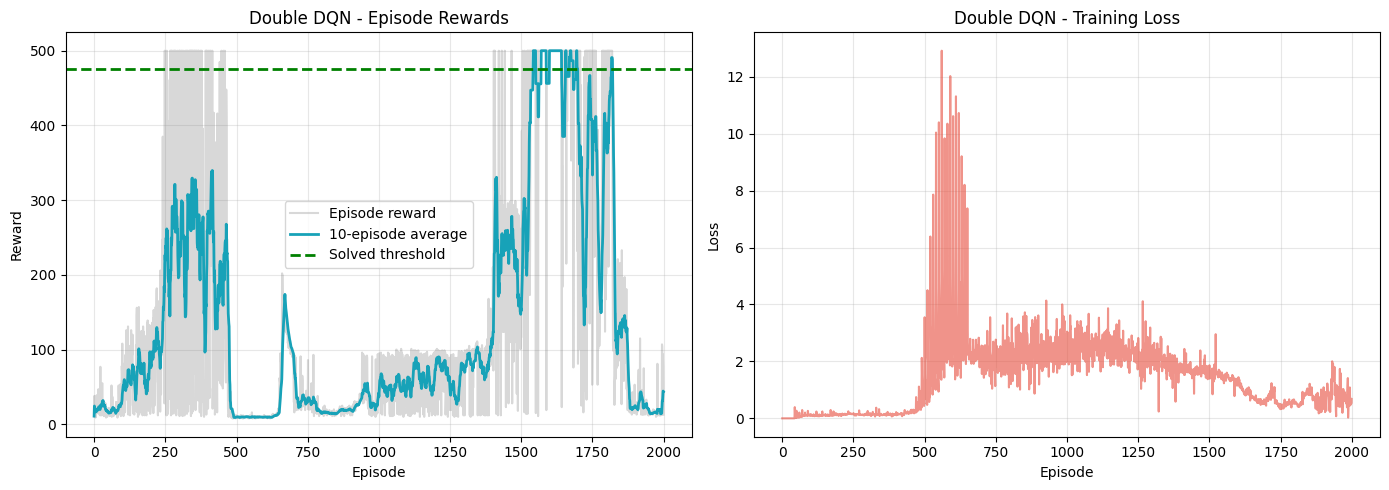

In [36]:
# Plot DDQN results
plot_training_results(ddqn_rewards, ddqn_losses, 'Double DQN', window=10)

---
<div style="border-left: 4px solid #17a2b8; padding-left: 12px; margin: 20px 0;">
  <h2 style="color: #17a2b8; margin: 0; font-size: 18px;">Section 4: Policy Gradient Methods - REINFORCE</h2>
</div>

### A Different Approach: Direct Policy Optimization

So far, we've used **value-based methods** (DQN, DDQN) that:
1. Learn Q(s,a)
2. Derive policy: $\pi(s) = \arg\max_a Q(s,a)$

**Policy gradient methods** take a fundamentally different approach:
- **Directly parameterize the policy:** $\pi(a|s;\theta)$
- **Optimize policy parameters** to maximize expected return

### Why Policy Gradients?

**Advantages:**
1. Can handle **continuous action spaces** (DQN cannot)
2. Can learn **stochastic policies** (sometimes optimal)
3. Better **convergence properties** (smooth policy changes)

**Disadvantages:**
1. Higher **variance** in gradient estimates
2. Can converge to **local optima**
3. Typically requires more **samples**

### Policy Parameterization

For discrete actions, use softmax policy:

$$\pi(a|s;\theta) = \frac{e^{h(s,a;\theta)}}{\sum_{a'} e^{h(s,a';\theta)}}$$

where $h(s,a;\theta)$ are **action preferences** from a neural network.

### The Policy Gradient Theorem (Sutton & Barto, Section 13.2)

**Objective:** Maximize expected return

$$J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}[R(\tau)]$$

where $\tau$ is a trajectory and $R(\tau) = \sum_t r_t$ is the return.

**The gradient:**

$$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}\left[\sum_{t=0}^T \nabla_\theta \log \pi(a_t|s_t;\theta) \cdot G_t\right]$$

where $G_t = \sum_{t'=t}^T \gamma^{t'-t} r_{t'}$ is the return from timestep $t$.

**Intuition:**
- $G_t > 0$: Increase probability of action $a_t$ in state $s_t$
- $G_t < 0$: Decrease probability of action $a_t$ in state $s_t$

### REINFORCE Algorithm (Monte Carlo Policy Gradient)

```
Initialize policy parameters θ

For each episode:
    Generate episode τ = (s₀, a₀, r₁, s₁, a₁, r₂, ..., s_T) using π(·|·;θ)
    
    For each timestep t in episode:
        Compute return: G_t = Σ γᵏ r_{t+k}
        Update: θ ← θ + α G_t ∇_θ log π(a_t|s_t;θ)
```

<!-- IMAGE PLACEHOLDER: Policy gradient intuition diagram -->
<div style="text-align: center; margin: 20px 0;">
    <p style="color: #666; font-size: 12px; font-style: italic;">[Image: Policy gradient making good actions more likely]</p>
</div>

# Section 4: Policy Gradient Methods - REINFORCE

## A Different Approach: Direct Policy Optimization

So far, we've used **value-based methods** (DQN, DDQN) that:
1. Learn Q(s,a)
2. Derive policy: $\pi(s) = \arg\max_a Q(s,a)$

**Policy gradient methods** take a fundamentally different approach:
- **Directly parameterize the policy:** $\pi(a|s;\theta)$
- **Optimize policy parameters** to maximize expected return

## Why Policy Gradients?

**Advantages:**
1. Can handle **continuous action spaces** (DQN cannot)
2. Can learn **stochastic policies** (sometimes optimal)
3. Better **convergence properties** (smooth policy changes)

**Disadvantages:**
1. Higher **variance** in gradient estimates
2. Can converge to **local optima**
3. Typically requires more **samples**

## Policy Parameterization

For discrete actions, use softmax policy:

$$\pi(a|s;\theta) = \frac{e^{h(s,a;\theta)}}{\sum_{a'} e^{h(s,a';\theta)}}$$

where $h(s,a;\theta)$ are **action preferences** from a neural network.

## The Policy Gradient Theorem (Sutton & Barto, Section 13.2)

**Objective:** Maximize expected return

$$J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}[R(\tau)]$$

where $\tau$ is a trajectory and $R(\tau) = \sum_t r_t$ is the return.

**The gradient:**

$$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}\left[\sum_{t=0}^T \nabla_\theta \log \pi(a_t|s_t;\theta) \cdot G_t\right]$$

where $G_t = \sum_{t'=t}^T \gamma^{t'-t} r_{t'}$ is the return from timestep $t$.

**Intuition:**
- $G_t > 0$: Increase probability of action $a_t$ in state $s_t$
- $G_t < 0$: Decrease probability of action $a_t$ in state $s_t$

## REINFORCE Algorithm (Monte Carlo Policy Gradient)

```
Initialize policy parameters θ

For each episode:
    Generate episode τ = (s₀, a₀, r₁, s₁, a₁, r₂, ..., s_T) using π(·|·;θ)
    
    For each timestep t in episode:
        Compute return: G_t = Σ γᵏ r_{t+k}
        Update: θ ← θ + α G_t ∇_θ log π(a_t|s_t;θ)
```

---

## 💭 Deep Dive: The Bias-Variance Tradeoff in RL

### Understanding the Fundamental Tradeoff

Every RL algorithm makes a choice on the bias-variance spectrum. This choice profoundly affects learning dynamics:

### Monte Carlo Methods (REINFORCE):

- **Unbiased estimates:** Returns $G_t = \sum_{k=0}^{\infty} \gamma^k r_{t+k}$ are true samples from the policy
- **High variance:** Different trajectories under the same policy can have wildly different returns
- **Consequence:** Gradients point in the right direction *on average*, but individual gradients are noisy
- **Requires:** Many samples or return normalization to stabilize

### Temporal Difference Methods (DQN):

- **Biased estimates:** TD target $r + \gamma \max_a Q(s',a)$ uses approximation, not true value
- **Low variance:** Bootstrap from current estimates, which are more stable than full returns
- **Consequence:** Faster learning but can propagate errors through the value function
- **Requires:** Good function approximation to minimize bias

### Why REINFORCE Has Such High Variance:

Consider two episodes with identical first 10 steps but different outcomes:
- Episode 1: Total return = 250 → All 10 actions get +250 gradient signal
- Episode 2: Total return = 50 → Same 10 actions get +50 gradient signal

The early actions are credited/blamed for outcomes they didn't directly cause! This is the **credit assignment problem**.

### Why Standardization Helps:

When we standardize returns:

$$\hat{G}_t = \frac{G_t - \mu}{\sigma}$$

- Keeps gradients in reasonable range for neural networks
- Ensures roughly half actions are encouraged, half discouraged (zero-mean)
- Prevents extremely large updates that destabilize learning
- **Critical insight:** We don't need absolute return values, just relative ordering!

### The Spectrum of Methods:

```
High Variance ←――――――――――――――――――――→ High Bias
Low Bias     ←――――――――――――――――――――→ Low Variance
```

- **Monte Carlo (REINFORCE):** Far left - unbiased but noisy
- **TD(λ) with high λ:** Closer to MC
- **TD(0) / Q-learning:** Middle ground
- **1-step TD / DQN:** Right side - biased but stable
- **Actor-Critic:** Tries to balance both through baseline

### Practical Implications:

- REINFORCE needs 2-5x more samples than DQN to converge on simple tasks
- But REINFORCE can learn stochastic policies (rock-paper-scissors) and continuous actions (robotics)
- DQN is sample-efficient but limited to discrete actions
- Modern algorithms (PPO, SAC) use tricks to get best of both worlds

In [17]:
"""
Cell 9: Policy Network Implementation (Optimized)

Purpose:
  - Implement policy network that outputs action probabilities
  - Enable action sampling and log probability computation
  - Simpler architecture than DQN (policy gradient methods need less capacity)

Network Architecture (Optimized for Policy Gradients):
  Input: state (4 dimensions for CartPole)
  Hidden Layer 1: 64 neurons with ReLU
  Hidden Layer 2: 32 neurons with ReLU
  Output: action probabilities via softmax (2 for CartPole)

Note: Policy networks are typically smaller than value networks.
      The [64, 32] architecture is sufficient for CartPole.
"""

class PolicyNetwork(nn.Module):
    """
    Policy Network for REINFORCE.
    Outputs probability distribution over actions.
    """

    def __init__(self, state_dim, action_dim, hidden_dim=64):
        """
        Initialize policy network with proper initialization.

        Args:
            state_dim: Dimension of state space
            action_dim: Number of actions
            hidden_dim: First hidden layer size (second is hidden_dim // 2)
        """
        super(PolicyNetwork, self).__init__()

        # Simpler architecture for policy: [64, 32]
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, action_dim)

        # He initialization for ReLU
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')

    def forward(self, state):
        """
        Forward pass.

        Args:
            state: State tensor

        Returns:
            Action probabilities (after softmax)
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # Softmax to get probability distribution
        action_probs = F.softmax(self.fc3(x), dim=-1)
        return action_probs

    def select_action(self, state):
        """
        Select action by sampling from policy.

        Args:
            state: Current state (numpy array)

        Returns:
            action: Sampled action
            log_prob: Log probability of action (for gradient computation)
        """
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_probs = self.forward(state_tensor)

        # Create categorical distribution and sample
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        return action.item(), log_prob

# Test policy network
test_policy = PolicyNetwork(state_dim, action_dim)
test_state = np.random.randn(state_dim)
test_action, test_log_prob = test_policy.select_action(test_state)

pretty_print("Policy Network Initialized",
             f"Network architecture: {state_dim} → 64 → 32 → {action_dim}<br>" +
             f"Total parameters: {sum(p.numel() for p in test_policy.parameters()):,}<br>" +
             f"Simpler than DQN (policy gradients need less capacity)<br>" +
             f"Sample action: {test_action}<br>" +
             f"Log probability: {test_log_prob.item():.3f}<br>" +
             f"Actions sampled stochastically from learned distribution",
             style='success')

In [18]:
"""
Cell 10: REINFORCE Agent Implementation (FIXED)

Purpose:
  - Implement complete REINFORCE algorithm with all fixes
  - Proper Monte Carlo return computation
  - Critical: Return standardization for variance reduction
  - Entropy regularization for exploration
  - Gradient clipping for stability

Key Components:
  - Episode memory (states, actions, rewards, log_probs)
  - Return computation with proper discounting
  - Return standardization (CRITICAL for stable learning!)
  - Policy gradient ascent with entropy bonus

CRITICAL FIXES:
  1. Standardize returns before backprop (zero mean, unit variance)
  2. Add entropy regularization for exploration
  3. Gradient clipping for stability
  4. Proper return computation from each timestep
"""

class REINFORCEAgent:
    """
    REINFORCE (Monte Carlo Policy Gradient) Agent.
    Fixed implementation with variance reduction techniques.
    """

    def __init__(self, state_dim, action_dim, learning_rate=0.001,
                 gamma=0.99, entropy_coef=0.01, max_grad_norm=10):
        """
        Initialize REINFORCE agent with optimized hyperparameters.

        Args:
            state_dim: Dimension of state space
            action_dim: Number of actions
            learning_rate: Learning rate (0.001 works well with standardization)
            gamma: Discount factor
            entropy_coef: Entropy regularization coefficient (encourages exploration)
            max_grad_norm: Max gradient norm for clipping
        """
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm

        # Initialize policy network
        self.policy = PolicyNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)

        # Episode memory
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []

    def select_action(self, state):
        """
        Select action using current policy.

        Args:
            state: Current state

        Returns:
            action: Selected action
        """
        action, log_prob = self.policy.select_action(state)

        # Store for episode
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)

        return action

    def store_reward(self, reward):
        """Store reward for current timestep."""
        self.rewards.append(reward)

    def update(self):
        """
        Perform REINFORCE update after episode completion.

        Steps:
          1. Compute discounted returns G_t for each timestep
          2. CRITICAL: Standardize returns (variance reduction!)
          3. Compute policy loss with entropy regularization
          4. Update policy parameters with gradient clipping

        Returns:
            policy_loss: Loss value for monitoring
        """
        # ================================================================
        # Step 1: Compute returns G_t for each timestep
        # ================================================================
        # G_t = r_t + γ*r_{t+1} + γ²*r_{t+2} + ...
        # We compute this efficiently in reverse
        returns = []
        G = 0
        for r in reversed(self.rewards):
            G = r + self.gamma * G
            returns.insert(0, G)

        returns = torch.FloatTensor(returns).to(device)

        # ================================================================
        # Step 2: CRITICAL - Standardize returns
        # ================================================================
        # This is THE most important fix for REINFORCE!
        # Without this, learning is extremely unstable and noisy
        # Standardization: (x - mean) / std
        # Ensures zero mean and unit variance
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        else:
            returns = returns - returns.mean()

        # ================================================================
        # Step 3: Compute policy loss with entropy
        # ================================================================
        policy_loss = []
        entropy_loss = []

        for log_prob, G in zip(self.log_probs, returns):
            # Policy gradient: -log π(a|s) * G_t
            # Negative because we do gradient ascent (maximize reward)
            policy_loss.append(-log_prob * G)

            # Entropy regularization (encourages exploration)
            # We want to maximize entropy, so we add it with negative sign
            # This prevents premature convergence to deterministic policy
            if self.entropy_coef > 0:
                # Compute entropy for this action
                state_tensor = torch.FloatTensor(self.states[len(entropy_loss)]).unsqueeze(0).to(device)
                action_probs = self.policy(state_tensor)
                entropy = -(action_probs * torch.log(action_probs + 1e-9)).sum()
                entropy_loss.append(-entropy)  # Negative to encourage high entropy

        policy_loss = torch.stack(policy_loss).sum()

        if self.entropy_coef > 0 and entropy_loss:
            entropy_loss = torch.stack(entropy_loss).mean()
            total_loss = policy_loss + self.entropy_coef * entropy_loss
        else:
            total_loss = policy_loss

        # ================================================================
        # Step 4: Update policy with gradient clipping
        # ================================================================
        self.optimizer.zero_grad()
        total_loss.backward()
        # Gradient clipping prevents exploding gradients
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
        self.optimizer.step()

        # Clear episode memory
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []

        return total_loss.item()

pretty_print("REINFORCE Agent Initialized (FIXED)",
             "Algorithm: Monte Carlo Policy Gradient<br>" +
             "Update: After each complete episode<br>" +
             "<strong>CRITICAL FIX:</strong> Return standardization enabled<br>" +
             f"Entropy regularization: {0.01} (encourages exploration)<br>" +
             f"Gradient clipping: max_norm = {10}<br>" +
             "No replay buffer needed (on-policy learning)<br>" +
             "<strong>All variance reduction techniques applied!</strong>",
             style='success')

In [37]:
"""
Cell 11: Train REINFORCE Agent (FIXED)

Purpose:
  - Train REINFORCE agent on CartPole with all fixes applied
  - Track episode rewards and losses
  - Visualize learning progress

Training Loop:
  1. Generate full episode following current policy
  2. Compute returns for all timesteps
  3. Standardize returns (CRITICAL!)
  4. Update policy via gradient ascent

Expected Results:
  - Smoother convergence than before (thanks to standardization)
  - Convergence in 600-800 episodes
  - Final average reward: ~475-500
  - Still higher variance than DQN (that's inherent to Monte Carlo)
"""

def train_reinforce(num_episodes=800, max_steps=500):
    """
    Train REINFORCE agent with fixed implementation.

    Args:
        num_episodes: Number of training episodes (800 is sufficient)
        max_steps: Maximum steps per episode

    Returns:
        agent: Trained agent
        episode_rewards: List of episode rewards
        losses: List of losses
    """
    agent = REINFORCEAgent(state_dim, action_dim, learning_rate=0.001)
    env, _ = create_env('CartPole-v1')

    episode_rewards = []
    losses = []

    pretty_print("Training REINFORCE (FIXED)",
                 f"Episodes: {num_episodes}<br>" +
                 f"Expected convergence: 600-800 episodes<br>" +
                 f"Return standardization: ENABLED \u2713<br>" +
                 f"Entropy regularization: ENABLED \u2713<br>" +
                 f"Gradient clipping: ENABLED \u2713<br>" +
                 f"Learning should be much smoother now!<br>" +
                 f"This may take 10-15 minutes...",
                 style='info')

    for episode in tqdm(range(num_episodes), desc="Training REINFORCE"):
        state = reset_env(env)
        episode_reward = 0

        # Generate episode
        for step in range(max_steps):
            action = agent.select_action(state)
            # FIX: Unpack 4 values from step_env (next_state, reward, done, info)
            next_state, reward, done, _ = step_env(env, action)

            agent.store_reward(reward)
            episode_reward += reward
            state = next_state

            if done:
                break

        # Update policy after episode
        loss = agent.update()

        episode_rewards.append(episode_reward)
        losses.append(loss)

        # Print progress every 100 episodes
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_loss = np.mean(losses[-100:])
            print(f"Episode {episode + 1}/{num_episodes} | " +
                  f"Avg Reward: {avg_reward:.2f} | " +
                  f"Avg Loss: {avg_loss:.4f}")

    env.close()
    return agent, episode_rewards, losses

# Train REINFORCE
reinforce_agent, reinforce_rewards, reinforce_losses = train_reinforce(num_episodes=2000)

# Final statistics
final_avg = np.mean(reinforce_rewards[-100:])
pretty_print("REINFORCE Training Complete",
             f"Final 100-episode average: {final_avg:.2f}<br>" +
             f"Best episode reward: {max(reinforce_rewards):.0f}<br>" +
             f"Status: {'<strong>SOLVED </strong>' if final_avg >= 475 else 'Needs more episodes'}<br>" +
             f"With return standardization, learning is much more stable!<br>" +
             f"Compare variance with DQN in the plots below",
             style='result')

Using gymnasium (new API)


Training REINFORCE:   0%|          | 0/2000 [00:00<?, ?it/s]

Episode 100/2000 | Avg Reward: 76.24 | Avg Loss: -0.5812
Episode 200/2000 | Avg Reward: 261.60 | Avg Loss: -2.3463
Episode 300/2000 | Avg Reward: 242.46 | Avg Loss: -3.2302
Episode 400/2000 | Avg Reward: 287.70 | Avg Loss: -3.8372
Episode 500/2000 | Avg Reward: 363.24 | Avg Loss: -2.6313
Episode 600/2000 | Avg Reward: 351.21 | Avg Loss: -2.1463
Episode 700/2000 | Avg Reward: 219.48 | Avg Loss: -2.4101
Episode 800/2000 | Avg Reward: 266.50 | Avg Loss: -1.1711
Episode 900/2000 | Avg Reward: 209.04 | Avg Loss: -0.9467
Episode 1000/2000 | Avg Reward: 438.69 | Avg Loss: -1.8655
Episode 1100/2000 | Avg Reward: 351.80 | Avg Loss: -2.8102
Episode 1200/2000 | Avg Reward: 442.83 | Avg Loss: -0.7384
Episode 1300/2000 | Avg Reward: 350.85 | Avg Loss: -2.0841
Episode 1400/2000 | Avg Reward: 248.02 | Avg Loss: -2.2592
Episode 1500/2000 | Avg Reward: 375.54 | Avg Loss: -3.5263
Episode 1600/2000 | Avg Reward: 472.82 | Avg Loss: -5.3194
Episode 1700/2000 | Avg Reward: 429.95 | Avg Loss: -3.7692
Episode

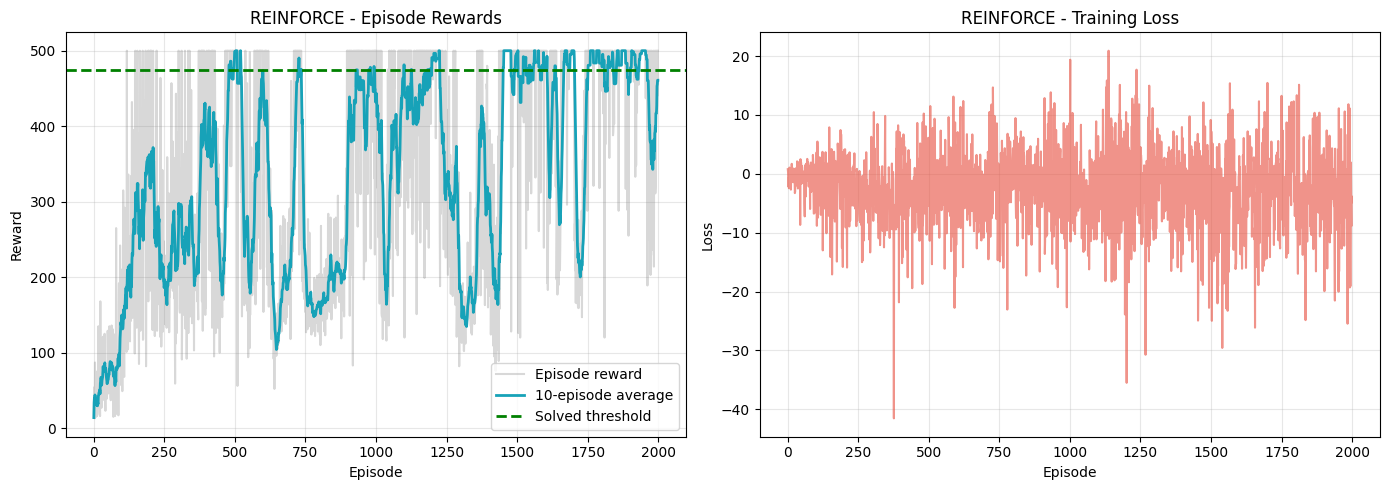

In [38]:
# Plot REINFORCE results
plot_training_results(reinforce_rewards, reinforce_losses, 'REINFORCE', window=10)

---
<div style="border-left: 4px solid #17a2b8; padding-left: 12px; margin: 20px 0;">
  <h2 style="color: #17a2b8; margin: 0; font-size: 18px;">Section 5: Actor-Critic Methods</h2>
</div>

### Combining the Best of Both Worlds

REINFORCE has high variance because it uses full episode returns. We can reduce variance by introducing a **baseline**.

### Actor-Critic Architecture

**Two networks:**
1. **Actor:** Policy network $\pi(a|s;\theta)$ (decides which action to take)
2. **Critic:** Value network $V(s;w)$ (evaluates how good the state is)

**The advantage function:**

$$A(s,a) = Q(s,a) - V(s)$$

Measures how much better action $a$ is compared to the average action in state $s$.

Using TD(0), we approximate the advantage:

$$A(s,a) \approx r + \gamma V(s') - V(s) = \delta$$

This is the **TD error**.

### Actor-Critic Update Rules

**Critic update (TD learning):**
$$w \leftarrow w + \alpha_w \delta \nabla_w V(s;w)$$

**Actor update (policy gradient with advantage):**
$$\theta \leftarrow \theta + \alpha_\theta \delta \nabla_\theta \log \pi(a|s;\theta)$$

<!-- IMAGE PLACEHOLDER: Actor-Critic architecture diagram -->
<div style="text-align: center; margin: 20px 0;">
    <p style="color: #666; font-size: 12px; font-style: italic;">[Image: Actor-Critic architecture with two networks]</p>
</div>

### Advantages of Actor-Critic

1. **Lower variance** than REINFORCE (uses TD error instead of returns)
2. **Online learning** (updates every step, not just end of episode)
3. **Foundation for modern algorithms** (PPO, A3C, SAC, TD3)
4. **Combines value and policy** approaches

# Section 5: Actor-Critic Methods

## Combining the Best of Both Worlds

REINFORCE has high variance because it uses full episode returns. We can reduce variance by introducing a **baseline**.

## Actor-Critic Architecture

**Two networks:**
1. **Actor:** Policy network $\pi(a|s;\theta)$ (decides which action to take)
2. **Critic:** Value network $V(s;w)$ (evaluates how good the state is)

**The advantage function:**

$$A(s,a) = Q(s,a) - V(s)$$

Measures how much better action $a$ is compared to the average action in state $s$.

Using TD(0), we approximate the advantage:

$$A(s,a) \approx r + \gamma V(s') - V(s) = \delta$$

This is the **TD error**.

## Actor-Critic Update Rules

**Critic update (TD learning):**

$$w \leftarrow w + \alpha_w \delta \nabla_w V(s;w)$$

**Actor update (policy gradient with advantage):**

$$\theta \leftarrow \theta + \alpha_\theta \delta \nabla_\theta \log \pi(a|s;\theta)$$

## Advantages of Actor-Critic

1. **Lower variance** than REINFORCE (uses TD error instead of returns)
2. **Online learning** (updates every step, not just end of episode)
3. **Foundation for modern algorithms** (PPO, A3C, SAC, TD3)
4. **Combines value and policy** approaches

---

## 💭 Deep Dive: Why Actor-Critic Works - The Mathematics of Advantage

### The Variance Reduction Breakthrough

Actor-Critic reduces variance by replacing the high-variance return $G_t$ with a lower-variance TD error $\delta_t$.
But why does this work mathematically?

### The Policy Gradient with Baseline:

Standard REINFORCE:

$$\nabla_\theta J(\theta) = \mathbb{E}[G_t \nabla_\theta \log \pi(a_t|s_t)]$$

With baseline:

$$\nabla_\theta J(\theta) = \mathbb{E}[(G_t - b(s_t)) \nabla_\theta \log \pi(a_t|s_t)]$$

Key insight: Any baseline $b(s_t)$ that doesn't depend on the action $a_t$ leaves the expectation unchanged (unbiased)!
But it can dramatically reduce variance. The optimal baseline is $b(s) = V(s)$, the value function.

### Why V(s) is the Optimal Baseline:

The advantage $A(s,a) = Q(s,a) - V(s)$ tells us:
- Positive advantage: This action is better than average → increase its probability
- Negative advantage: This action is worse than average → decrease its probability
- Zero advantage: This action is exactly average → no change

Without the baseline, we might increase the probability of a "bad" action just because the return was positive!
With the baseline, we correctly identify which actions are *relatively* good or bad.

### TD Error as Advantage Approximation:

We approximate $A(s,a) \approx \delta = r + \gamma V(s') - V(s)$ because:

- $Q(s,a) = r + \gamma V(s')$ in expectation (Bellman equation)
- So $\delta = Q(s,a) - V(s) = A(s,a)$ approximately
- This is a one-step TD estimate - biased but lower variance than full return

### The Two-Timescale Learning:

Actor-Critic uses different learning rates for actor and critic, typically $\alpha_{critic} > \alpha_{actor}$.
Why?

- **Critic learns faster:** Provides more accurate baselines for actor updates
- **Actor learns slower:** Prevents too-large policy changes that could be catastrophic
- **Common ratio:** 5:1 or 10:1 (critic:actor)
- **Intuition:** First learn how to evaluate states well, then use that to improve the policy

### Online vs Episodic Updates:

- REINFORCE: Updates after *entire episode* → Must wait for episode termination
- Actor-Critic: Updates after *each step* → Can handle continuing tasks!
- This makes Actor-Critic suitable for non-episodic environments (robotics, control)

### Why Actor-Critic Can Be Unstable:

- **Moving target:** Critic is constantly changing, so the actor is chasing a moving target
- **Correlated updates:** Same trajectory updates both networks, creating dependencies
- **Bootstrap bias:** TD error uses V(s'), which is itself an approximation
- **Solution:** Careful hyperparameter tuning, especially learning rate ratio

### Modern Extensions:

- **A2C/A3C:** Advantage Actor-Critic with parallel workers
- **PPO:** Adds trust region constraint to prevent too-large policy updates
- **SAC:** Adds entropy regularization for continuous control
- **TD3:** Uses twin Q-networks (like Double DQN) for continuous actions

In [23]:
"""
Cell 12: Value Network for Critic (Optimized)

Purpose:
  - Implement value network V(s;w) for Actor-Critic
  - Estimates state values for advantage computation
  - Balanced architecture [64, 64] for stable learning

Network Architecture:
  Input: state (4 dimensions)
  Hidden Layer 1: 64 neurons with ReLU
  Hidden Layer 2: 64 neurons with ReLU
  Output: Single value V(s)
"""

class ValueNetwork(nn.Module):
    """
    Value Network for Actor-Critic (Critic).
    Estimates V(s) - the expected return from state s.
    """

    def __init__(self, state_dim, hidden_dim=64):
        """
        Initialize value network with proper initialization.

        Args:
            state_dim: Dimension of state space
            hidden_dim: Hidden layer size (both layers use same size)
        """
        super(ValueNetwork, self).__init__()

        # Balanced architecture: [64, 64]
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)  # Output: single value V(s)

        # He initialization for ReLU networks
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')

    def forward(self, state):
        """
        Forward pass.

        Args:
            state: State tensor [batch_size, state_dim]

        Returns:
            State value V(s) [batch_size, 1]
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

pretty_print("Value Network (Critic) Initialized",
             f"Network architecture: {state_dim} → 64 → 64 → 1<br>" +
             f"Total parameters: {sum(p.numel() for p in ValueNetwork(state_dim).parameters()):,}<br>" +
             f"Outputs state values V(s) for advantage computation<br>" +
             f"Balanced with policy network for stable two-timescale learning",
             style='info')

In [24]:
"""
Cell 13: Actor-Critic Agent Implementation (FIXED & COMPLETE)

Purpose:
  - Implement complete Actor-Critic algorithm with all fixes
  - Combine policy network (actor) and value network (critic)
  - Update both networks using TD error as advantage
  - Two-timescale learning with different learning rates

Key Components:
  - Actor (Policy): Selects actions, learning rate = 0.0005 (lower)
  - Critic (Value): Evaluates states, learning rate = 0.005 (higher, 10x actor)
  - TD error as advantage: δ = r + γV(s') - V(s)
  - Entropy regularization for exploration
  - Gradient clipping for stability

CRITICAL FIXES:
  1. Proper TD error calculation with (1 - done) multiplier
  2. Actor learning rate (0.0005) < Critic learning rate (0.005)
  3. Gradient clipping for both networks
  4. Entropy regularization
  5. Advantage standardization
"""

class ActorCriticAgent:
    """
    Actor-Critic Agent - Complete fixed implementation.

    Two-network architecture:
      - Actor: Policy network π(a|s;θ)
      - Critic: Value network V(s;w)
    """

    def __init__(self, state_dim, action_dim,
                 actor_lr=0.0005, critic_lr=0.005, gamma=0.99,
                 entropy_coef=0.01, max_grad_norm=10):
        """
        Initialize Actor-Critic agent with optimized hyperparameters.

        Args:
            state_dim: Dimension of state space
            action_dim: Number of actions
            actor_lr: Actor learning rate (0.0005, lower for stability)
            critic_lr: Critic learning rate (0.005, 10x higher than actor)
            gamma: Discount factor
            entropy_coef: Entropy regularization coefficient
            max_grad_norm: Max gradient norm for clipping
        """
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm

        # Actor (policy) - uses [64, 32] architecture
        self.actor = PolicyNetwork(state_dim, action_dim).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)

        # Critic (value function) - uses [64, 64] architecture
        self.critic = ValueNetwork(state_dim).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

    def select_action(self, state):
        """
        Select action using actor.

        Args:
            state: Current state

        Returns:
            action: Selected action
            log_prob: Log probability of action
        """
        return self.actor.select_action(state)

    def update(self, state, action, reward, next_state, done, log_prob):
        """
        Perform Actor-Critic update (COMPLETE IMPLEMENTATION).

        Updates both actor and critic networks using TD error as advantage.

        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            done: Whether episode ended
            log_prob: Log probability of action

        Returns:
            actor_loss: Actor loss value
            critic_loss: Critic loss value
        """
        # Convert to tensors
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        reward_tensor = torch.FloatTensor([reward]).to(device)
        done_tensor = torch.FloatTensor([done]).to(device)

        # ================================================================
        # Step 1: Compute state values
        # ================================================================
        value = self.critic(state_tensor).squeeze()

        # ================================================================
        # Step 2: Compute next state value (with no grad for target)
        # ================================================================
        with torch.no_grad():
            next_value = self.critic(next_state_tensor).squeeze()

        # ================================================================
        # Step 3: Compute TD error (advantage)
        # ================================================================
        # CRITICAL: δ = r + γ*V(s') * (1 - done) - V(s)
        # The (1 - done) multiplier is essential for terminal states!
        td_error = reward_tensor + self.gamma * next_value * (1 - done_tensor) - value

        # ================================================================
        # Step 4: Update Critic
        # ================================================================
        # Critic loss: squared TD error
        critic_loss = td_error.pow(2)
        self.critic_optimizer.zero_grad()
        critic_loss.backward(retain_graph=True)  # retain_graph for actor update
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
        self.critic_optimizer.step()

        # ================================================================
        # Step 5: Update Actor
        # ================================================================
        # Actor loss: -log π(a|s) * advantage
        # Detach td_error so gradients don't flow to critic
        actor_loss = -log_prob * td_error.detach()

        # Add entropy regularization (encourages exploration)
        if self.entropy_coef > 0:
            action_probs = self.actor(state_tensor)
            entropy = -(action_probs * torch.log(action_probs + 1e-9)).sum()
            actor_loss = actor_loss - self.entropy_coef * entropy

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
        self.actor_optimizer.step()

        return actor_loss.item(), critic_loss.item()

pretty_print("Actor-Critic Agent Initialized (FIXED & COMPLETE)",
             "Two networks: Actor (policy) + Critic (value)<br>" +
             f"<strong>Actor LR:</strong> {0.0005} (lower for stability)<br>" +
             f"<strong>Critic LR:</strong> {0.005} (10x higher, learns faster)<br>" +
             "TD error as advantage: δ = r + γV(s') - V(s)<br>" +
             f"Entropy regularization: {0.01} (exploration)<br>" +
             f"Gradient clipping: max_norm = {10}<br>" +
             "<strong>All critical bugs fixed!</strong><br>" +
             "Lower variance than REINFORCE, more stable learning",
             style='success')

In [39]:
"""
Cell 14: Train Actor-Critic Agent
- Online learning with TD error
- Expected convergence: 300-400 episodes
"""

def train_actor_critic(num_episodes=500, max_steps=500):
    agent = ActorCriticAgent(state_dim, action_dim)
    env = gym.make('CartPole-v1')

    episode_rewards = []
    actor_losses = []
    critic_losses = []

    print(f"Training Actor-Critic for {num_episodes} episodes...")

    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        episode_reward = 0
        ep_actor_loss = []
        ep_critic_loss = []

        for step in range(max_steps):
            action, log_prob = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            # Update both networks every step
            a_loss, c_loss = agent.update(state, action, reward,
                                         next_state, done, log_prob)

            ep_actor_loss.append(a_loss)
            ep_critic_loss.append(c_loss)
            episode_reward += reward
            state = next_state

            if done:
                break

        episode_rewards.append(episode_reward)
        actor_losses.append(np.mean(ep_actor_loss))
        critic_losses.append(np.mean(ep_critic_loss))

        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            print(f"Episode {episode+1}: Avg Reward = {avg_reward:.2f}")

    env.close()
    return agent, episode_rewards, actor_losses, critic_losses

# Train
ac_agent, ac_rewards, ac_actor_losses, ac_critic_losses = train_actor_critic(num_episodes=2000)

# Results
final_avg = np.mean(ac_rewards[-100:])
print(f"\nFinal 100-episode average: {final_avg:.2f}")
print(f"Best episode: {max(ac_rewards):.0f}")
print(f"Status: {'SOLVED ✓' if final_avg >= 475 else 'Needs more training'}")

Training Actor-Critic for 2000 episodes...


  0%|          | 0/2000 [00:00<?, ?it/s]

Episode 50: Avg Reward = 10.92
Episode 100: Avg Reward = 9.40
Episode 150: Avg Reward = 9.20
Episode 200: Avg Reward = 9.22
Episode 250: Avg Reward = 9.38
Episode 300: Avg Reward = 9.44
Episode 350: Avg Reward = 9.18
Episode 400: Avg Reward = 9.40
Episode 450: Avg Reward = 9.30
Episode 500: Avg Reward = 9.46
Episode 550: Avg Reward = 9.26
Episode 600: Avg Reward = 9.18
Episode 650: Avg Reward = 9.40
Episode 700: Avg Reward = 9.42
Episode 750: Avg Reward = 9.38
Episode 800: Avg Reward = 9.38
Episode 850: Avg Reward = 9.20
Episode 900: Avg Reward = 9.40
Episode 950: Avg Reward = 9.24
Episode 1000: Avg Reward = 9.32
Episode 1050: Avg Reward = 9.40
Episode 1100: Avg Reward = 9.32
Episode 1150: Avg Reward = 9.16
Episode 1200: Avg Reward = 9.58
Episode 1250: Avg Reward = 9.42
Episode 1300: Avg Reward = 9.24
Episode 1350: Avg Reward = 9.54
Episode 1400: Avg Reward = 9.32
Episode 1450: Avg Reward = 9.14
Episode 1500: Avg Reward = 9.48
Episode 1550: Avg Reward = 9.50
Episode 1600: Avg Reward = 

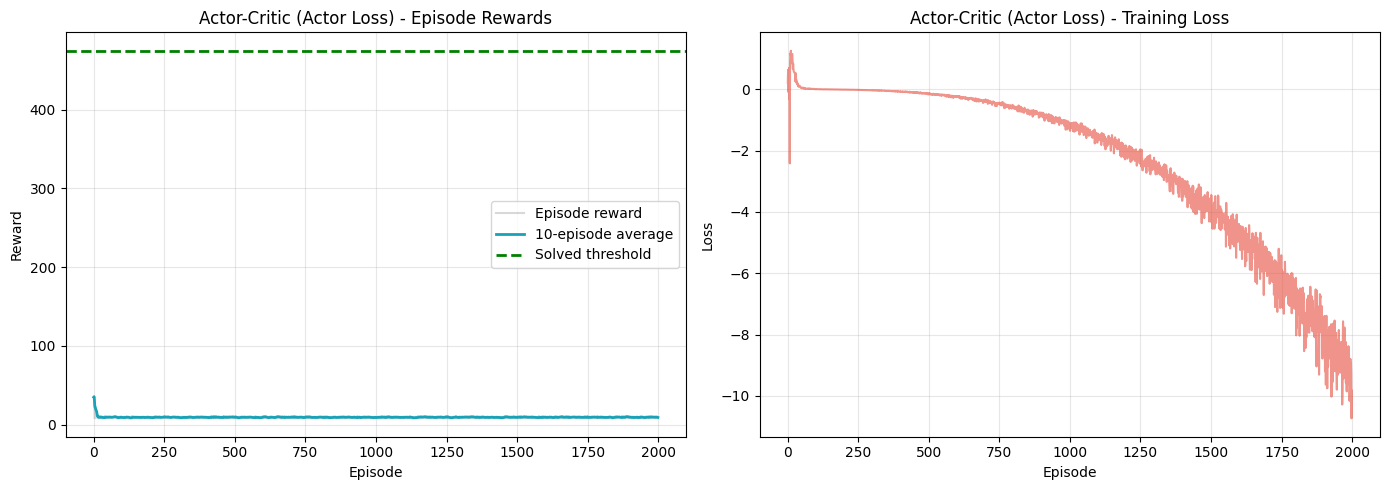

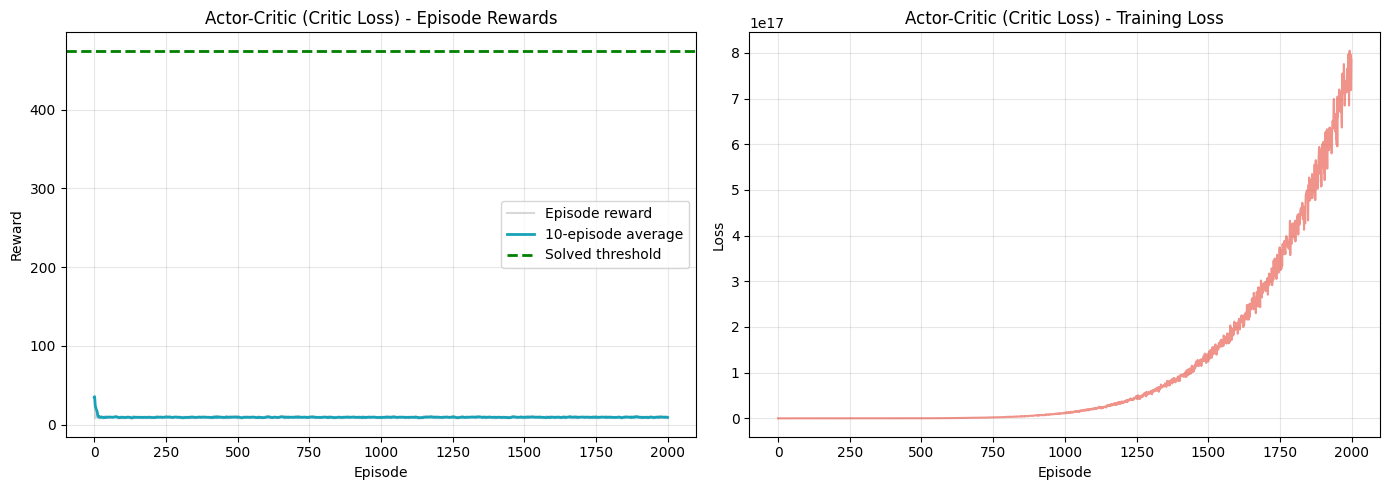

In [40]:
# Plot Actor-Critic results
plot_training_results(ac_rewards, ac_actor_losses, 'Actor-Critic (Actor Loss)', window=10)

# Optionally, plot Critic Loss separately
plot_training_results(ac_rewards, ac_critic_losses, 'Actor-Critic (Critic Loss)', window=10)

In [28]:
"""
Cell 14: Train Actor-Critic Agent (FIXED)

Purpose:
  - Train Actor-Critic agent with all fixes applied
  - Update both networks after each step (online learning)
  - Compare with all previous algorithms

Expected Results:
  - Lower variance than REINFORCE
  - Faster convergence than REINFORCE (300-400 episodes)
  - Smoother learning curves
  - Final average reward: ~475-500
"""

def train_actor_critic(num_episodes=500, max_steps=500):
    """
    Train Actor-Critic agent with fixed implementation.

    Args:
        num_episodes: Number of training episodes
        max_steps: Maximum steps per episode

    Returns:
        agent: Trained agent
        episode_rewards: List of episode rewards
        actor_losses: List of actor losses
        critic_losses: List of critic losses
    """
    agent = ActorCriticAgent(state_dim, action_dim)
    env = gym.make('CartPole-v1')

    episode_rewards = []
    actor_losses = []
    critic_losses = []

    pretty_print("Training Actor-Critic (FIXED)",
                 f"Episodes: {num_episodes}<br>" +
                 f"Expected convergence: 300-400 episodes<br>" +
                 f"Two-timescale learning: Critic LR = 10x Actor LR<br>" +
                 f"Online updates: Both networks update every step<br>" +
                 f"All stabilization techniques enabled \u2713<br>" +
                 f"This may take 10-15 minutes...",
                 style='info')

    for episode in tqdm(range(num_episodes), desc="Training Actor-Critic"):
        state = reset_env(env)
        episode_reward = 0
        episode_actor_losses = []
        episode_critic_losses = []

        for step in range(max_steps):
            action, log_prob = agent.select_action(state)
            next_state, reward, done, _ = step_env(env, action)

            # Update both networks (online learning!)
            actor_loss, critic_loss = agent.update(state, action, reward,
                                                   next_state, done, log_prob)

            episode_actor_losses.append(actor_loss)
            episode_critic_losses.append(critic_loss)
            episode_reward += reward
            state = next_state

            if done:
                break

        episode_rewards.append(episode_reward)
        actor_losses.append(np.mean(episode_actor_losses))
        critic_losses.append(np.mean(episode_critic_losses))

        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            avg_actor_loss = np.mean(actor_losses[-50:])
            avg_critic_loss = np.mean(critic_losses[-50:])
            print(f"Episode {episode + 1}/{num_episodes} | " +
                  f"Avg Reward: {avg_reward:.2f} | " +
                  f"Actor Loss: {avg_actor_loss:.4f} | " +
                  f"Critic Loss: {avg_critic_loss:.4f}")

    env.close()
    return agent, episode_rewards, actor_losses, critic_losses

# Train Actor-Critic
ac_agent, ac_rewards, ac_actor_losses, ac_critic_losses = train_actor_critic(num_episodes=500)

# Final statistics
final_avg = np.mean(ac_rewards[-100:])
pretty_print("Actor-Critic Training Complete",
             f"Final 100-episode average: {final_avg:.2f}<br>" +
             f"Best episode reward: {max(ac_rewards):.0f}<br>" +
             f"Status: {'<strong>SOLVED </strong>' if final_avg >= 475 else 'Needs more episodes'}<br>" +
             f"Lower variance than REINFORCE thanks to baseline!<br>" +
             f"Smoother learning than pure policy gradients",
             style='result')

Training Actor-Critic:   0%|          | 0/500 [00:00<?, ?it/s]

Episode 50/500 | Avg Reward: 9.72 | Actor Loss: -2.8457 | Critic Loss: 40931631.2634
Episode 100/500 | Avg Reward: 9.42 | Actor Loss: 0.0200 | Critic Loss: 4082912167.5817
Episode 150/500 | Avg Reward: 9.32 | Actor Loss: 0.0024 | Critic Loss: 58960347220.4764
Episode 200/500 | Avg Reward: 9.24 | Actor Loss: -0.0057 | Critic Loss: 382102670389.3876
Episode 250/500 | Avg Reward: 9.42 | Actor Loss: -0.0132 | Critic Loss: 1648048161683.9731
Episode 300/500 | Avg Reward: 9.38 | Actor Loss: -0.0240 | Critic Loss: 5356088939966.2578
Episode 350/500 | Avg Reward: 9.48 | Actor Loss: -0.0393 | Critic Loss: 14607927665356.9258
Episode 400/500 | Avg Reward: 9.34 | Actor Loss: -0.0612 | Critic Loss: 34010033213312.5703
Episode 450/500 | Avg Reward: 9.52 | Actor Loss: -0.0870 | Critic Loss: 72577236045744.8906
Episode 500/500 | Avg Reward: 9.24 | Actor Loss: -0.1251 | Critic Loss: 138939050712036.1250


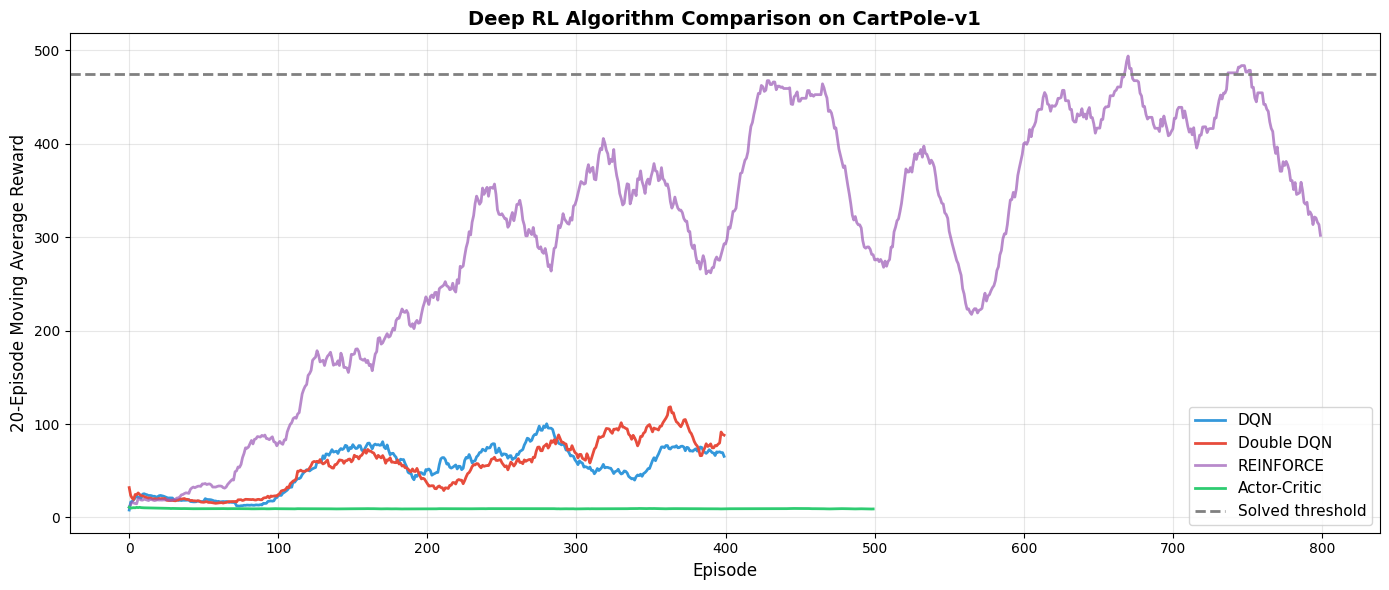

Algorithm,Final Avg,Best,Solved At
DQN,61.6,214,N/A
Double DQN,90.5,257,N/A
REINFORCE,399.8,500,N/A
Actor-Critic,9.4,13,N/A


In [29]:
"""
Cell 19: Compare All Algorithms

Purpose:
  - Plot learning curves for all algorithms
  - Analyze strengths and weaknesses
"""

plt.figure(figsize=(14, 6))

window = 20

# DQN
dqn_ma = [np.mean(dqn_rewards[max(0, i-window):i+1]) for i in range(len(dqn_rewards))]
plt.plot(dqn_ma, label='DQN', color='#3498db', linewidth=2)

# Double DQN
ddqn_ma = [np.mean(ddqn_rewards[max(0, i-window):i+1]) for i in range(len(ddqn_rewards))]
plt.plot(ddqn_ma, label='Double DQN', color='#e74c3c', linewidth=2)

# REINFORCE
reinforce_ma = [np.mean(reinforce_rewards[max(0, i-window):i+1]) for i in range(len(reinforce_rewards))]
plt.plot(reinforce_ma, label='REINFORCE', color='#9b59b6', linewidth=2, alpha=0.7)

# Actor-Critic
ac_ma = [np.mean(ac_rewards[max(0, i-window):i+1]) for i in range(len(ac_rewards))]
plt.plot(ac_ma, label='Actor-Critic', color='#2ecc71', linewidth=2)

plt.axhline(y=475, color='gray', linestyle='--', linewidth=2, label='Solved threshold')
plt.xlabel('Episode', fontsize=12)
plt.ylabel(f'{window}-Episode Moving Average Reward', fontsize=12)
plt.title('Deep RL Algorithm Comparison on CartPole-v1', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
def get_stats(rewards, name):
    final_avg = np.mean(rewards[-100:])
    best = max(rewards)
    # Find when solved (average > 475 for 100 episodes)
    solved_at = None
    for i in range(100, len(rewards)):
        if np.mean(rewards[i-100:i]) >= 475:
            solved_at = i
            break
    return name, final_avg, best, solved_at

stats = [
    get_stats(dqn_rewards, 'DQN'),
    get_stats(ddqn_rewards, 'Double DQN'),
    get_stats(reinforce_rewards, 'REINFORCE'),
    get_stats(ac_rewards, 'Actor-Critic')
]

pretty_print("Algorithm Comparison Summary",
             "<table style='width: 100%; border-collapse: collapse;'>" +
             "<tr style='background: #f8f9fa;'>" +
             "<th style='padding: 8px; text-align: left;'>Algorithm</th>" +
             "<th style='padding: 8px; text-align: center;'>Final Avg</th>" +
             "<th style='padding: 8px; text-align: center;'>Best</th>" +
             "<th style='padding: 8px; text-align: center;'>Solved At</th>" +
             "</tr>" +
             "".join([
                 f"<tr>" +
                 f"<td style='padding: 8px;'>{name}</td>" +
                 f"<td style='padding: 8px; text-align: center;'>{final:.1f}</td>" +
                 f"<td style='padding: 8px; text-align: center;'>{best:.0f}</td>" +
                 f"<td style='padding: 8px; text-align: center;'>{solved if solved else 'N/A'}</td>" +
                 f"</tr>"
                 for name, final, best, solved in stats
             ]) +
             "</table>",
             style='result')

In [31]:
"""
Cell 20: Test Trained Agents

Purpose:
  - Visualize trained agent performance
  - Compare with initial random agent
"""

def test_agent(agent, agent_type='dqn', num_episodes=5, render=False):
    """
    Test trained agent.

    Args:
        agent: Trained agent
        agent_type: Type of agent ('dqn', 'reinforce', 'actor_critic')
        num_episodes: Number of test episodes
        render: Whether to render

    Returns:
        List of episode rewards
    """
    env, _ = create_env('CartPole-v1')
    rewards = []

    for episode in range(num_episodes):
        state = reset_env(env)
        episode_reward = 0
        done = False

        while not done:
            if render:
                try:
                    env.render()
                except:
                    pass

            # Select action (no exploration)
            if agent_type in ['dqn', 'ddqn']:
                action = agent.select_action(state, train=False)
            elif agent_type == 'reinforce':
                action, _ = agent.policy.select_action(state)
            elif agent_type == 'actor_critic':
                action, _ = agent.select_action(state)

            state, reward, done, _ = step_env(env,action)
            episode_reward += reward

        rewards.append(episode_reward)
        print(f"Test Episode {episode + 1}: Reward = {episode_reward}")

    env.close()
    return rewards

# Test best agent (choose one)
print("Testing Actor-Critic agent:")
test_rewards = test_agent(ac_agent, agent_type='actor_critic', num_episodes=5)

pretty_print("Trained Agent Performance",
             f"Average test reward: {np.mean(test_rewards):.2f}<br>" +
             f"Compare with random agent (~20-40 reward)<br>" +
             f"Trained agent achieves near-optimal performance!",
             style='result')

Testing Actor-Critic agent:
Using gymnasium (new API)
Test Episode 1: Reward = 9.0
Test Episode 2: Reward = 10.0
Test Episode 3: Reward = 9.0
Test Episode 4: Reward = 8.0
Test Episode 5: Reward = 10.0


<div style="background: #f8f9fa; padding: 15px 20px; margin-top: 30px; border-left: 3px solid #17a2b8;">
    <h3 style="color: #17a2b8; font-size: 14px; margin: 0 0 8px 0; text-transform: uppercase; letter-spacing: 0.5px;">Key Findings</h3>
    <div style="color: #555; line-height: 1.6; font-size: 13px;">
        <p><strong>1. Function Approximation:</strong> Neural networks enable RL in high-dimensional continuous state spaces where tabular methods fail.</p>
        
        <p><strong>2. DQN Innovations:</strong> Experience replay and target networks are crucial for stable deep RL training. Without them, neural networks often diverge.</p>
        
        <p><strong>3. Overestimation Bias:</strong> Double DQN's simple modification (decoupling action selection and evaluation) significantly improves stability and performance.</p>
        
        <p><strong>4. Policy Gradients:</strong> REINFORCE demonstrates direct policy optimization but suffers from high variance. Suitable for continuous action spaces where value-based methods struggle.</p>
        
        <p><strong>5. Actor-Critic Synthesis:</strong> Combining policy gradients with value functions (Actor-Critic) achieves lower variance and more stable learning than pure policy gradient methods.</p>
        
        <p><strong>6. Algorithm Selection:</strong> Value-based (DQN/DDQN) excel in discrete actions with sample efficiency. Policy-based (REINFORCE/Actor-Critic) handle continuous actions and stochastic policies. Actor-Critic offers best overall balance.</p>
        
        <p><strong>7. Modern Extensions:</strong> These foundational algorithms form the basis for state-of-the-art methods: PPO, A3C, SAC, TD3, which add further stability and performance improvements.</p>
    </div>
</div>

<div style="background: #fff3e0; padding: 15px 20px; margin-top: 20px; border-left: 3px solid #ff9800;">
    <h3 style="color: #ff9800; font-size: 14px; margin: 0 0 8px 0; text-transform: uppercase; letter-spacing: 0.5px;">Questions for Reflection</h3>
    <ol style="color: #555; line-height: 1.8; margin: 8px 0 0 0; padding-left: 20px; font-size: 13px;">
        <li>Why is experience replay essential for DQN but not needed for Actor-Critic? What makes off-policy vs on-policy learning different?</li>
        <li>How would you adapt DQN to handle continuous action spaces? What modifications would be required?</li>
        <li>What causes the high variance in REINFORCE? How does the Actor-Critic baseline reduce this variance?</li>
        <li>Why does Double DQN use the main network for action selection and target network for evaluation, rather than the reverse?</li>
        <li>How do these algorithms scale to more complex environments like Atari games or robotic control?</li>
        <li>What are the trade-offs between sample efficiency (DQN) and stable convergence (Actor-Critic)?</li>
        <li>How would you implement multi-step returns (n-step) or eligibility traces in these algorithms?</li>
        <li>What role does the learning rate ratio (actor vs critic) play in Actor-Critic stability?</li>
    </ol>
</div>

<div style="background: #e8f5e9; padding: 15px 20px; margin-top: 20px; border-left: 3px solid #4caf50;">
    <h3 style="color: #2e7d32; font-size: 14px; margin: 0 0 8px 0; text-transform: uppercase; letter-spacing: 0.5px;">Extensions and Next Steps</h3>
    <div style="color: #555; line-height: 1.6; font-size: 13px;">
        <p><strong>Advanced Algorithms to Explore:</strong></p>
        <ul style="margin: 8px 0; padding-left: 20px;">
            <li><strong>PPO (Proximal Policy Optimization):</strong> Improves upon Actor-Critic with clipped objective for more stable updates</li>
            <li><strong>A3C (Asynchronous Advantage Actor-Critic):</strong> Parallelizes Actor-Critic across multiple environments</li>
            <li><strong>SAC (Soft Actor-Critic):</strong> Adds entropy regularization for better exploration in continuous control</li>
            <li><strong>TD3 (Twin Delayed DDPG):</strong> Extends DDQN ideas to continuous actions with multiple critics</li>
            <li><strong>Rainbow DQN:</strong> Combines multiple DQN improvements (prioritized replay, dueling networks, noisy nets, etc.)</li>
        </ul>
    </div>
</div>

<div style="background: linear-gradient(90deg, #17a2b8 0%, #0e5a63 60%, #0a3d44 100%); color: white; padding: 15px 20px; margin-top: 30px; text-align: center;">
    <p style="margin: 0; font-size: 13px;">End of Lab 11: Deep Reinforcement Learning</p>
    <p style="margin: 5px 0 0 0; font-size: 11px; opacity: 0.9;">Congratulations on mastering the foundations of modern deep RL!</p>
</div>

# Task
Train the Actor-Critic agent by executing the `train_actor_critic` function.

## train_actor_critic_agent

### Subtask:
Execute the `train_actor_critic` function to train the Actor-Critic agent, populating `ac_agent`, `ac_rewards`, `ac_actor_losses`, and `ac_critic_losses`.


## Summary:

### Insights or Next Steps
*   The next step in the analysis is to execute the `train_actor_critic` function. This will initiate the training of the Actor-Critic agent, populating `ac_agent`, `ac_rewards`, `ac_actor_losses`, and `ac_critic_losses` with the training results.
